# encodign / decoding analyses
2022/1/25

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp
import scipy.stats as stats
import pandas as pd
from pathlib import Path
from importlib import reload
import sklearn.linear_model as lm
import sklearn.kernel_ridge as kr
import sklearn.metrics as sk_metrics
from sklearn.model_selection import cross_val_score

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns

import TreeMazeAnalyses2,Analyses.tree_maze_functions as tmf
import TreeMazeAnalyses2.Analyses.experiment_info as ei
import TreeMazeAnalyses2.Analyses.plot_functions as pf
import TreeMazeAnalyses2.Utils.robust_stats as rs

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual

from joblib import delayed, Parallel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
ei = reload(ei)
info = ei.SummaryInfo()

In [3]:
%%time
info.update_paths()

CPU times: user 214 ms, sys: 24.8 ms, total: 239 ms
Wall time: 243 ms


In [4]:
subject_widget = widgets.Dropdown(options=info.subjects)
session_widget = widgets.Dropdown(options=info.sessions_by_subject[subject_widget.value])
task_widget = widgets.Dropdown(options=['T3', 'OF'])

def update_sessions(*args):
    all_sessions = info.sessions_by_subject[subject_widget.value]
    task_sessions = [session for session in all_sessions if task_widget.value in session]
    session_widget.options = task_sessions

def get_session(subject, task, session):
    return ei.SubjectSessionInfo(subject, session)

subject_widget.observe(update_sessions, names='value')
task_widget.observe(update_sessions, names='value')
o=widgets.interactive(get_session, subject=subject_widget, task=task_widget, session=session_widget)
display(o)


interactive(children=(Dropdown(description='subject', options=('Li', 'Ne', 'Cl', 'Al', 'Ca', 'Mi'), value='Li'…

In [5]:
session = session_widget.value
session_info = o.result
print(session_info)


Session Information for subject Li, session Li_T3g_060418
Number of curated units: 20
Methods listed below can be executed with get_{method}(), eg. get_spikes():
  -> track_data. Executed = True
  -> spikes. Executed = True
  -> binned_spikes. Executed = True
  -> fr. Executed = True
  -> pos_zones. Executed = True
  -> event_table. Executed = True
  -> trial_zone_rates. Executed = False
  -> zone_rates_comps. Executed = True
  -> zone_rates_remap. Executed = True
  -> pop_zone_rates_remap. Executed = True
  -> bal_conds_seg_rates. Executed = True
  -> bal_conds_seg_boot_rates. Executed = nan
  -> zone_encoder_lag. Executed = True
  -> zone_encoder_cue. Executed = True

To run all analyses use run_analyses().



## decoder comps

In [12]:
tmf = reload(tmf)
ta = tmf.TrialAnalyses(session_info)

In [78]:
%%time
cue_types=['none','fixed','inter']

ze = {}
for cue in cue_types:
    ze[cue] = tmf.ZoneEncoder(session_info)
    ze[cue].update_feature_params(cue_type=cue)
    ze[cue].prepare_xval_data()
    ze[cue].get_model_fits()

CPU times: user 2min 14s, sys: 1.57 s, total: 2min 16s
Wall time: 53.8 s


In [79]:
%%time
tmf = reload(tmf)
feature_types = ['encoder', 'neural']
target = 'cue'
de = pd.DataFrame(np.zeros((3,2),dtype=object),index=cue_types,columns=feature_types)

for cue in cue_types:
    for feature in feature_types:
        temp = tmf.ZoneDecoder(ze[cue], feature_type=feature, target_type=target)
        temp.get_decoder_model_fit()
        de.loc[cue,feature] = temp

CPU times: user 1min 31s, sys: 826 ms, total: 1min 32s
Wall time: 1min 4s


In [80]:
%%time
for cue in cue_types:
    for feature in feature_types:
        de.loc[cue,feature].get_trial_zone_evidence_table()
        de.loc[cue,feature].get_cummulative_trial_decoder()

CPU times: user 47.6 s, sys: 2.46 s, total: 50.1 s
Wall time: 23.9 s


In [96]:
feature='encoder'
cue='fixed'
evz = de.loc[cue,feature].trial_zone_perf_table.pivot(index='trial', columns='zones', values='L')
cmp = de.loc[cue,feature].trial_zone_cummulative_perf_table.pivot(index='trial', columns='zones', values='P(L)')

In [102]:
Cue = de.loc[cue,feature].trial_info_table['cue'][de.loc[cue,feature].ze.valid_trials]

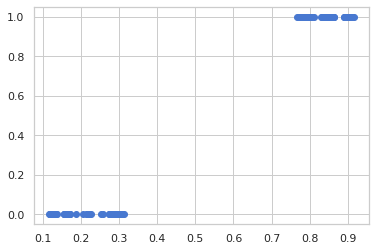

In [112]:
plt.scatter(evz['D'], Cue=='L')

In [92]:
feature='encoder'
cue='fixed'
de.loc[cue,feature].trial_zone_cummulative_perf_table

,trial,target,zones,pred,acc,fold,bac,P(L)
0,0.0,L,H,L,1.0,0,1.00000,9.999900e-01
1,1.0,L,H,L,1.0,4,1.00000,9.999212e-01
2,2.0,L,H,L,1.0,4,1.00000,9.998876e-01
3,3.0,L,H,L,1.0,2,1.00000,9.999965e-01
4,4.0,L,H,L,1.0,0,1.00000,9.999926e-01
...,...,...,...,...,...,...,...,...
2795,139.0,R,G,R,1.0,1,0.96875,7.412261e-10
2796,140.0,R,G,R,1.0,4,1.00000,1.100501e-02
2797,141.0,R,G,R,1.0,4,1.00000,3.334386e-05
2798,142.0,R,G,R,1.0,4,1.00000,2.349389e-04


In [91]:
de

,encoder,neural
none,<Analyses.tree_maze_functions.ZoneDecoder obje...,<Analyses.tree_maze_functions.ZoneDecoder obje...
fixed,<Analyses.tree_maze_functions.ZoneDecoder obje...,<Analyses.tree_maze_functions.ZoneDecoder obje...
inter,<Analyses.tree_maze_functions.ZoneDecoder obje...,<Analyses.tree_maze_functions.ZoneDecoder obje...


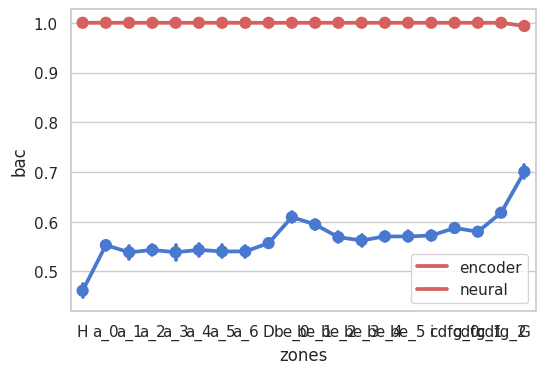

In [84]:
f,ax=plt.subplots(dpi=100)

colors=['r','b']
cue='fixed'
for ii, feature in enumerate(feature_types):
    sns.pointplot(data=de.loc[cue,feature].trial_zone_cummulative_perf_table, x='zones', y='bac', ax=ax, color=colors[ii], label=feature)

ax.legend(feature_types)

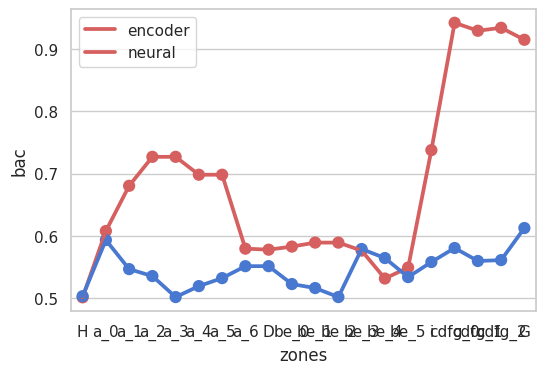

In [56]:
f,ax=plt.subplots(dpi=100)

colors=['r','b']
cue='inter'
for ii, feature in enumerate(feature_types):
    sns.pointplot(data=de.loc[cue,feature].trial_zone_cummulative_perf_table, x='zones', y='bac', ax=ax, color=colors[ii], label=feature)

ax.legend(feature_types)

In [14]:
session_info.get_zone_encoder_cue(overwrite=True)

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/home/alexgonzalez/anacon

,unit,split,fold,metric,score,lag,decay,cue_type,unit_type
0,0,train,0,r2,0.115362,50,inverse,none,mua
1,1,train,0,r2,0.041789,50,inverse,none,mua
2,0,test,0,r2,0.071204,50,inverse,none,mua
3,1,test,0,r2,0.019553,50,inverse,none,mua
4,0,train,1,r2,0.083367,50,inverse,none,mua
5,1,train,1,r2,0.027457,50,inverse,none,mua
6,0,test,1,r2,0.112412,50,inverse,none,mua
7,1,test,1,r2,0.040599,50,inverse,none,mua
8,0,train,2,r2,0.090462,50,inverse,none,mua
9,1,train,2,r2,0.027136,50,inverse,none,mua


## cue comparison analysis

In [15]:
def zone_encoding_cue_analysis(session_info, max_lag=50, decay_func='inverse'):
    """
    Fit encoder models with different cue modeling types in addition to the zones. Two main types, fixed and inter.
        -> fixed: fixed cue signal by trial
        -> inter: zones modeled separetely by cue
    :param session_info: session info object
    :param max_lag: int
    :param decay_funcs: inverse
    :return:
        dataframe of R2 results.
    """

    ze = tmf.ZoneEncoder(session_info)

    results = pd.DataFrame()

    for cue_type in ze.cue_types:
        ze.update_feature_params(cue_type=cue_type, max_lag=max_lag, decay=decay_func)
        ze.prepare_xval_data()
        ze.get_model_fits()
        enc_scores = ze.get_scores().copy()
        enc_scores['lag'] = max_lag
        enc_scores['decay'] = decay_func
        enc_scores['cue_type'] = cue_type

        results = pd.concat((results, enc_scores))

    results.reset_index(drop=True, inplace=True)
    results['unit_type'] = results.unit.map(session_info.unit_type_map)

    return results

In [40]:
%%time
tmf = reload(tmf)
res = zone_encoding_cue_analysis(session_info)

CPU times: user 57.8 s, sys: 737 ms, total: 58.5 s
Wall time: 19.3 s


<AxesSubplot:xlabel='cue_type', ylabel='score'>

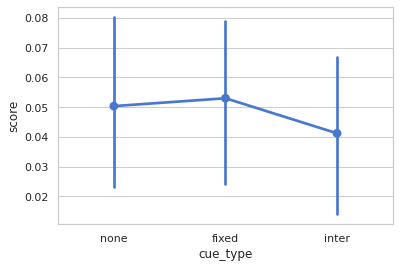

In [41]:
sns.pointplot(data=res[res.split=='test'], x='cue_type', y='score')

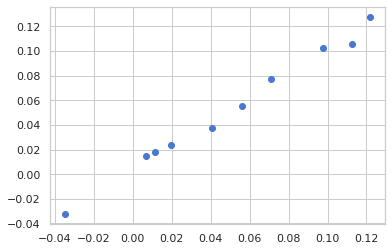

In [42]:
x = res[(res.split=='test') & (res.cue_type=='none') ]['score']
y = res[(res.split=='test') & (res.cue_type=='fixed') ]['score']

plt.scatter(x,y)

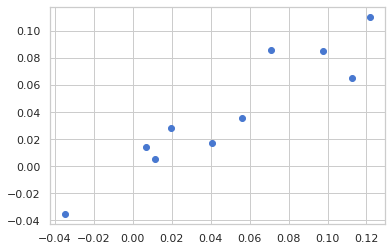

In [43]:
x = res[(res.split=='test') & (res.cue_type=='none') ]['score']
y = res[(res.split=='test') & (res.cue_type=='inter') ]['score']

plt.scatter(x,y)

In [18]:
%%time
tmf = reload(tmf)
cue_type='fixed'
ze = tmf.ZoneEncoder(session_info)
ze.update_feature_params(cue_type=cue_type)
ze.prepare_xval_data()
ze.get_model_fits()
enc_scores = ze.get_scores().copy()

CPU times: user 10.5 s, sys: 176 ms, total: 10.7 s
Wall time: 2.74 s


/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [20]:
ze.get_fold_prediction(1)

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


array([[3.62939505, 2.71446603],
       [3.62939505, 2.71446603],
       [3.62939505, 2.71446603],
       ...,
       [0.9244704 , 0.98283091],
       [0.9244704 , 0.98283091],
       [0.9244704 , 0.98283091]])

In [27]:
ze.get_fold_features(1).columns

Index(['H', 'a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'a_6', 'D', 'b_0', 'b_1',
       'b_2', 'b_3', 'b_4', 'b_5', 'i1', 'c_0', 'c_1', 'c_2', 'G1', 'd_0',
       'd_1', 'd_2', 'G2', 'e_0', 'e_1', 'e_2', 'e_3', 'e_4', 'e_5', 'i2',
       'f_0', 'f_1', 'f_2', 'G3', 'g_0', 'g_1', 'g_2', 'G4', 'RC', 'LC'],
      dtype='object')

In [28]:
X=ze.get_fold_features(1,'train')

In [26]:
ze.model_fits[1].feature_names_in_

array(['H', 'a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'a_6', 'D', 'b_0',
       'b_1', 'b_2', 'b_3', 'b_4', 'b_5', 'i1', 'c_0', 'c_1', 'c_2', 'G1',
       'd_0', 'd_1', 'd_2', 'G2', 'e_0', 'e_1', 'e_2', 'e_3', 'e_4',
       'e_5', 'i2', 'f_0', 'f_1', 'f_2', 'G3', 'g_0', 'g_1', 'g_2', 'G4',
       'LC', 'RC'], dtype=object)

In [30]:
fold=1
split='test'
X=ze.get_fold_features(fold,split)
ze.model_fits[fold].predict(X)

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


array([[3.62939505, 2.71446603],
       [3.62939505, 2.71446603],
       [3.62939505, 2.71446603],
       ...,
       [0.9244704 , 0.98283091],
       [0.9244704 , 0.98283091],
       [0.9244704 , 0.98283091]])

In [31]:
Xte=ze.get_fold_features(fold,'test')
Xtr=ze.get_fold_features(fold,'train')

In [37]:
list(zip(Xtr.columns,Xte.columns))

[('H', 'H'),
 ('a_0', 'a_0'),
 ('a_1', 'a_1'),
 ('a_2', 'a_2'),
 ('a_3', 'a_3'),
 ('a_4', 'a_4'),
 ('a_5', 'a_5'),
 ('a_6', 'a_6'),
 ('D', 'D'),
 ('b_0', 'b_0'),
 ('b_1', 'b_1'),
 ('b_2', 'b_2'),
 ('b_3', 'b_3'),
 ('b_4', 'b_4'),
 ('b_5', 'b_5'),
 ('i1', 'i1'),
 ('c_0', 'c_0'),
 ('c_1', 'c_1'),
 ('c_2', 'c_2'),
 ('G1', 'G1'),
 ('d_0', 'd_0'),
 ('d_1', 'd_1'),
 ('d_2', 'd_2'),
 ('G2', 'G2'),
 ('e_0', 'e_0'),
 ('e_1', 'e_1'),
 ('e_2', 'e_2'),
 ('e_3', 'e_3'),
 ('e_4', 'e_4'),
 ('e_5', 'e_5'),
 ('i2', 'i2'),
 ('f_0', 'f_0'),
 ('f_1', 'f_1'),
 ('f_2', 'f_2'),
 ('G3', 'G3'),
 ('g_0', 'g_0'),
 ('g_1', 'g_1'),
 ('g_2', 'g_2'),
 ('G4', 'G4'),
 ('LC', 'RC'),
 ('RC', 'LC')]

In [42]:
%%time
tmf = reload(tmf)
cue_type='fixed'
ze = tmf.ZoneEncoder(session_info)
ze.update_feature_params(cue_type=cue_type)
ze.prepare_xval_data()
ze.get_model_fits()
enc_scores = ze.get_scores().copy()

CPU times: user 40.4 s, sys: 722 ms, total: 41.1 s
Wall time: 6.89 s


In [43]:
enc_scores

,unit,split,fold,metric,score
0,0,train,0,r2,0.079364
1,1,train,0,r2,0.330943
2,2,train,0,r2,0.310881
3,3,train,0,r2,0.085584
4,4,train,0,r2,0.22298
...,...,...,...,...,...
195,15,test,4,r2,0.219043
196,16,test,4,r2,0.127846
197,17,test,4,r2,0.118573
198,18,test,4,r2,0.026121


In [27]:
ze.tmz.n_all_segs, ze.tmz.all_segs_names

(39,
 ['H',
  'a_0',
  'a_1',
  'a_2',
  'a_3',
  'a_4',
  'a_5',
  'a_6',
  'D',
  'b_0',
  'b_1',
  'b_2',
  'b_3',
  'b_4',
  'b_5',
  'i1',
  'c_0',
  'c_1',
  'c_2',
  'G1',
  'd_0',
  'd_1',
  'd_2',
  'G2',
  'e_0',
  'e_1',
  'e_2',
  'e_3',
  'e_4',
  'e_5',
  'i2',
  'f_0',
  'f_1',
  'f_2',
  'G3',
  'g_0',
  'g_1',
  'g_2',
  'G4',
  'LC',
  'RC'])

## API Test

In [77]:
%%time
tmf = reload(tmf)
ze = tmf.ZoneEncoder(session_info)

CPU times: user 23.9 s, sys: 555 ms, total: 24.5 s
Wall time: 3.65 s


In [78]:
%%time
ze.prepare_xval_data()
ze.get_model_fits()

CPU times: user 4.66 s, sys: 95.7 ms, total: 4.76 s
Wall time: 1.05 s


{0: LinearRegression(fit_intercept=False),
 1: LinearRegression(fit_intercept=False),
 2: LinearRegression(fit_intercept=False),
 3: LinearRegression(fit_intercept=False),
 4: LinearRegression(fit_intercept=False)}

In [79]:
enc_scores = ze.get_scores()
enc_scores.groupby(['unit'])['score'].mean()

unit
0     0.057213
1     0.213091
2     0.238438
3     0.063798
4     0.211328
5     0.083743
6     0.033864
7     0.030451
8     0.137312
9     0.156765
10    0.008898
11    0.054744
12    0.067019
13    0.027157
14    0.046917
15    0.184784
16    0.138431
17    0.089696
18    0.032007
19    0.024583
Name: score, dtype: float64

In [123]:
enc_scores.groupby(['unit', 'split'])['score'].mean().reset_index()

,unit,split,score
0,0,test,0.054357
1,0,train,0.060068
2,1,test,0.211345
3,1,train,0.214836
4,2,test,0.235508
5,2,train,0.241368
6,3,test,0.058601
7,3,train,0.068994
8,4,test,0.208094
9,4,train,0.214562


## test of lag functions

In [124]:
%%time
tmf = reload(tmf)
def lag_encoding_analysis(lags=None, decay_funcs = None):
    if lags is None:
        lags = [-50,0,50]
        
    if decay_funcs is None:
        decay_funcs=['inverse']
        
    ze = tmf.ZoneEncoder(session_info)
    
    results = pd.DataFrame() 
    
    for decay in decay_funcs:
        for lag in lags:
            ze.update_feature_params(max_lag=lag, decay=decay)
            ze.prepare_xval_data()
            ze.get_model_fits()
            enc_scores = ze.get_scores().copy()
            enc_scores['lag'] = lag
            enc_scores['decay'] = decay
            
            results = pd.concat((results,enc_scores))
        
    results.reset_index(drop=True, inplace=True)
    
    unit_type=np.zeros(session_info.n_units, dtype='object')
    unit_type[session_info.cell_ids] = 'cell'
    unit_type[session_info.mua_ids] = 'mua'
    unit_type_map = dict(zip(np.arange(session_info.n_units),unit_type))
    
    results['unit_type'] = results.unit.map(unit_type_map)
    
    return results


CPU times: user 31.5 ms, sys: 0 ns, total: 31.5 ms
Wall time: 30 ms


In [82]:
%%time
tmf = reload(tmf)

decay_funcs = ['constant', 'linear', 'linear_pos', 'inverse']
mr2 = lag_encoding_analysis(decay_funcs=decay_funcs)

CPU times: user 2min 19s, sys: 1.76 s, total: 2min 21s
Wall time: 1min 8s


<AxesSubplot:xlabel='lag', ylabel='score'>

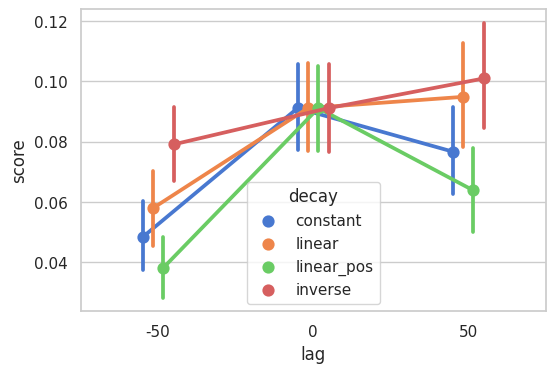

In [107]:
f,ax=plt.subplots(dpi=100)
sns.pointplot(data= mr2[(mr2.split=='test')],x='lag',y='score', hue='decay', dodge=0.2,ax=ax)

In [98]:
unit_type=np.zeros(session_info.n_units, dtype='object')
unit_type[session_info.cell_ids] = 'cell'
unit_type[session_info.mua_ids] = 'mua'
unit_type_map = dict(zip(np.arange(session_info.n_units),unit_type))

In [100]:
mr2['unit_type'] = mr2.unit.map(unit_type_map)

In [106]:
mfr = mr2.groupby(['unit','split','decay','lag','unit_type'])['score'].mean().reset_index()

<AxesSubplot:xlabel='lag', ylabel='score'>

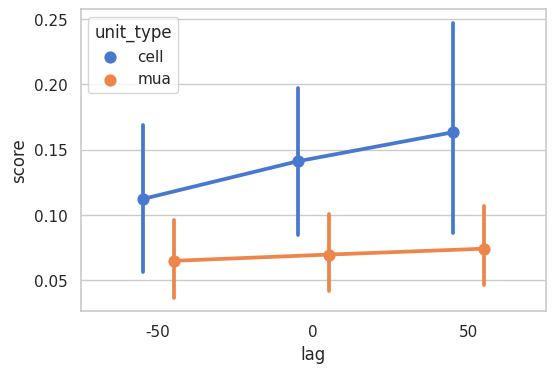

In [117]:
f,ax=plt.subplots(dpi=100)
sns.pointplot(data= mfr[(mfr.split=='test') & (mfr.decay=='inverse')],x='lag',y='score', hue='unit_type', ax=ax, dodge=0.2)

In [61]:
%%time
tmf = reload(tmf)
ze = tmf.ZoneEncoder(session_info)

CPU times: user 22.7 s, sys: 416 ms, total: 23.1 s
Wall time: 3.67 s


(-50.0, 0.0)

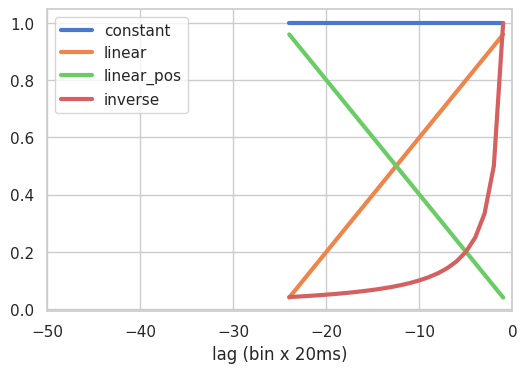

In [71]:
decay_funcs = ['constant', 'linear', 'linear_pos', 'inverse']

max_lag=-25
sgn = np.sign(max_lag)
lags = np.arange(sgn, max_lag, sgn)

f,ax=plt.subplots(dpi=100)
for decay in decay_funcs:
    ze.update_feature_params(max_lag=max_lag, decay=decay)
    amp = ze._get_decay_func()
    ax.plot(lags,amp(lags), label=decay, lw=3)
ax.legend()
ax.set_xlabel('lag (bin x 20ms)')
ax.set_xlim([-50,0])

### API test

In [ ]:
session_info.get_zone

In [42]:
amp(lags)

1

# encoding models

In [6]:
%%time
tmf = reload(tmf)
ze = tmf.ZoneEncoder(session_info)

CPU times: user 21.8 s, sys: 431 ms, total: 22.3 s
Wall time: 3.32 s


In [7]:
%%time
ze.prepare_xval_data()
ze.get_model_fits()
ze._get_trial_ts_splits()

CPU times: user 3.37 s, sys: 95.8 ms, total: 3.47 s
Wall time: 1.08 s


In [8]:
enc_scores = ze.get_scores()

<AxesSubplot:xlabel='split', ylabel='score'>

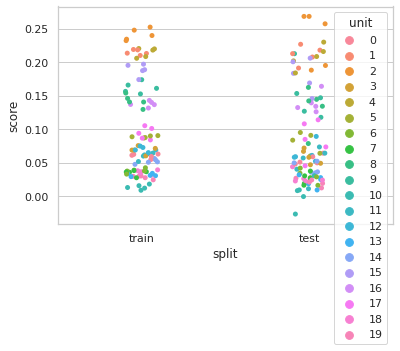

In [9]:
sns.stripplot(data=enc_scores, x='split', y='score', hue='unit')

In [11]:
avg_enc_scores = enc_scores.groupby(['unit', 'split', 'metric']).mean()
avg_enc_scores = avg_enc_scores.reset_index()
avg_enc_scores = avg_enc_scores[['unit', 'split', 'score']]


<AxesSubplot:xlabel='split', ylabel='score'>

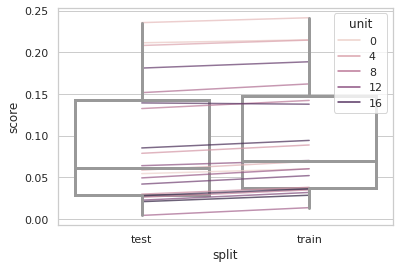

In [12]:
sns.lineplot(data=avg_enc_scores, x='split', y='score', hue='unit', estimator=None, units='unit', alpha=0.7, hue_order=['train','test'], color='#5F9EA0')
sns.boxplot(data=avg_enc_scores, x='split', y='score', hue_order=['train','test'], whis=10, showcaps=False, color='white', linewidth=3)


In [13]:
ze._get_trial_ts_splits()
ze._get_zone_ts_splits()

In [14]:
%%time
feature_params = dict(split_cue=True)
ze_cue = tmf.ZoneEncoder(session_info, feature_params=feature_params)
ze_cue.prepare_xval_data()
ze_cue.get_model_fits()


CPU times: user 49.1 s, sys: 580 ms, total: 49.7 s
Wall time: 27.6 s


{0: LinearRegression(fit_intercept=False),
 1: LinearRegression(fit_intercept=False),
 2: LinearRegression(fit_intercept=False),
 3: LinearRegression(fit_intercept=False),
 4: LinearRegression(fit_intercept=False)}

In [15]:
cue_enc_scores = ze_cue.get_scores()
avg_cue_enc_scores = enc_scores.groupby(['unit', 'split', 'metric']).mean()
avg_cue_enc_scores = avg_cue_enc_scores.reset_index()
avg_cue_enc_scores = avg_cue_enc_scores[['unit', 'split', 'score']]

In [16]:
split='test'
df = enc_scores[enc_scores.split==split].copy()
df['cue_score'] = cue_enc_scores[cue_enc_scores.split==split]['score']

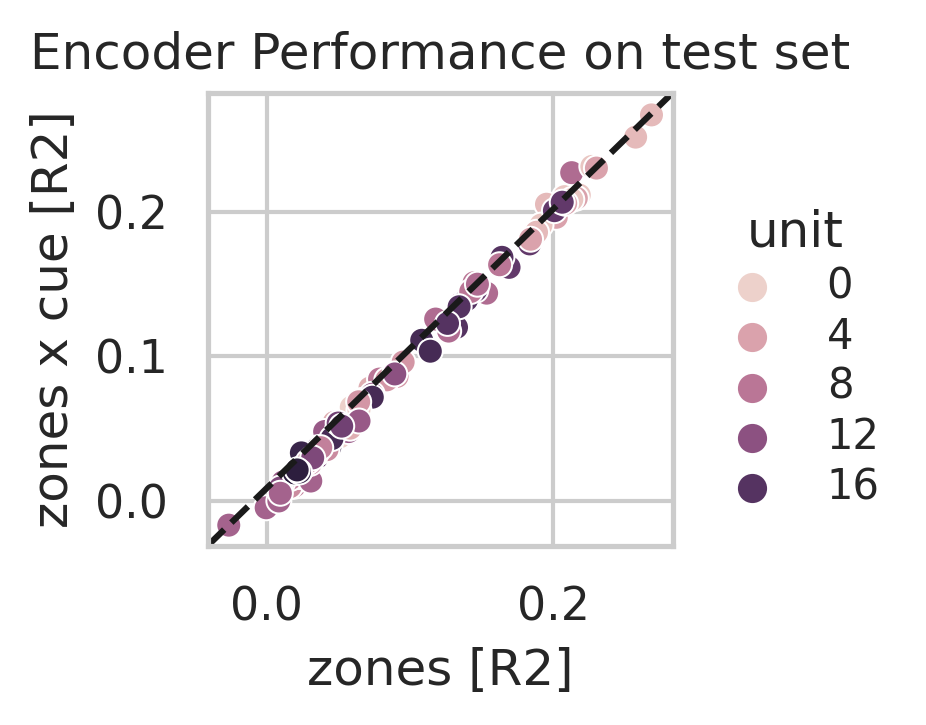

In [17]:
f,ax=plt.subplots(figsize=(2,2),dpi=300)
ax= sns.scatterplot(data=df, x='score',y='cue_score', hue='unit', ax=ax)
ax.plot([0,1],[0,1], '--k', transform=ax.transAxes)
ax.set_xlabel('zones [R2]')
ax.set_ylabel('zones x cue [R2]')
ax.set_title('Encoder Performance on test set')

ha, la = ax.get_legend_handles_labels()
ax.get_legend().remove()

ax.legend(ha,la,bbox_to_anchor = [1,0,0.2,0.5], loc='lower left', frameon=False, fontsize='small', markerscale=1, labelspacing=0.2,title='unit')

In [19]:
%%time
feature_params = dict(split_cue=True, max_lag=50)
ze_cue_lag50 = tmf.ZoneEncoder(session_info, feature_params=feature_params)
ze_cue_lag50.prepare_xval_data()
ze_cue_lag50.get_model_fits()

feature_params = dict(split_cue=True, max_lag=-50)
ze_cue_lagn50 = tmf.ZoneEncoder(session_info, feature_params=feature_params)
ze_cue_lagn50.prepare_xval_data()
ze_cue_lagn50.get_model_fits()

CPU times: user 1min 20s, sys: 1.03 s, total: 1min 21s
Wall time: 33.8 s


{0: LinearRegression(fit_intercept=False),
 1: LinearRegression(fit_intercept=False),
 2: LinearRegression(fit_intercept=False),
 3: LinearRegression(fit_intercept=False),
 4: LinearRegression(fit_intercept=False)}

In [20]:
%%time
feature_params = dict(split_cue=False, max_lag=50)
ze_lag50 = tmf.ZoneEncoder(session_info, feature_params=feature_params)
ze_lag50.prepare_xval_data()
ze_lag50.get_model_fits()

feature_params = dict(split_cue=False, max_lag=-50)
ze_lagn50 = tmf.ZoneEncoder(session_info, feature_params=feature_params)
ze_lagn50.prepare_xval_data()
ze_lagn50.get_model_fits()

CPU times: user 1min 3s, sys: 944 ms, total: 1min 4s
Wall time: 21.4 s


{0: LinearRegression(fit_intercept=False),
 1: LinearRegression(fit_intercept=False),
 2: LinearRegression(fit_intercept=False),
 3: LinearRegression(fit_intercept=False),
 4: LinearRegression(fit_intercept=False)}

In [21]:
%%time
cue_lag50_enc_scores = ze_cue_lag50.get_scores()
cue_lagn50_enc_scores = ze_cue_lagn50.get_scores()

lag50_enc_scores = ze_lag50.get_scores()
lagn50_enc_scores = ze_lagn50.get_scores()


CPU times: user 4.58 s, sys: 79.4 ms, total: 4.66 s
Wall time: 479 ms


In [22]:
df['cue_lag50_score'] = cue_lag50_enc_scores[cue_lag50_enc_scores.split==split]['score']
df['cue_lagn50_score'] = cue_lagn50_enc_scores[cue_lagn50_enc_scores.split==split]['score']
df['lag50_score'] = lag50_enc_scores[lag50_enc_scores.split==split]['score']
df['lagn50_score'] = lagn50_enc_scores[lagn50_enc_scores.split==split]['score']

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:ylabel='unit'>

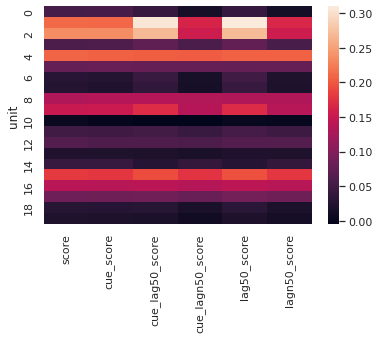

In [27]:
sns.heatmap(df.groupby('unit').mean().iloc[:,1:])

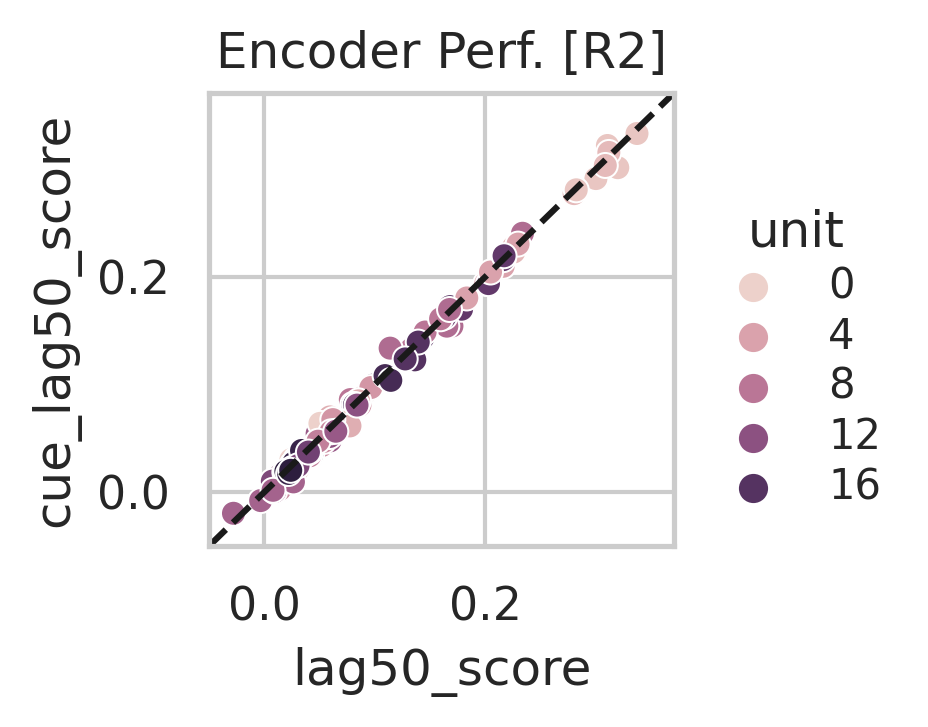

In [23]:
x='lag50_score'
y='cue_lag50_score'

f,ax=plt.subplots(figsize=(2,2),dpi=300)
ax= sns.scatterplot(data=df, x=x,y=y, hue='unit', ax=ax)
max_val = max(df[x].max(), df[y].max())
ax.set_ylim([-0.05, max_val*1.1])
ax.set_xlim([-0.05, max_val*1.1])
#ax.axis('square')
ax.plot([0,1],[0,1], '--k', transform=ax.transAxes)
ax.set_title('Encoder Perf. [R2]')

ha, la = ax.get_legend_handles_labels()
ax.get_legend().remove()

ax.legend(ha,la,bbox_to_anchor = [1,0,0.2,0.5], loc='lower left', frameon=False, fontsize='small', markerscale=1, labelspacing=0.2,title='unit')

<AxesSubplot:>

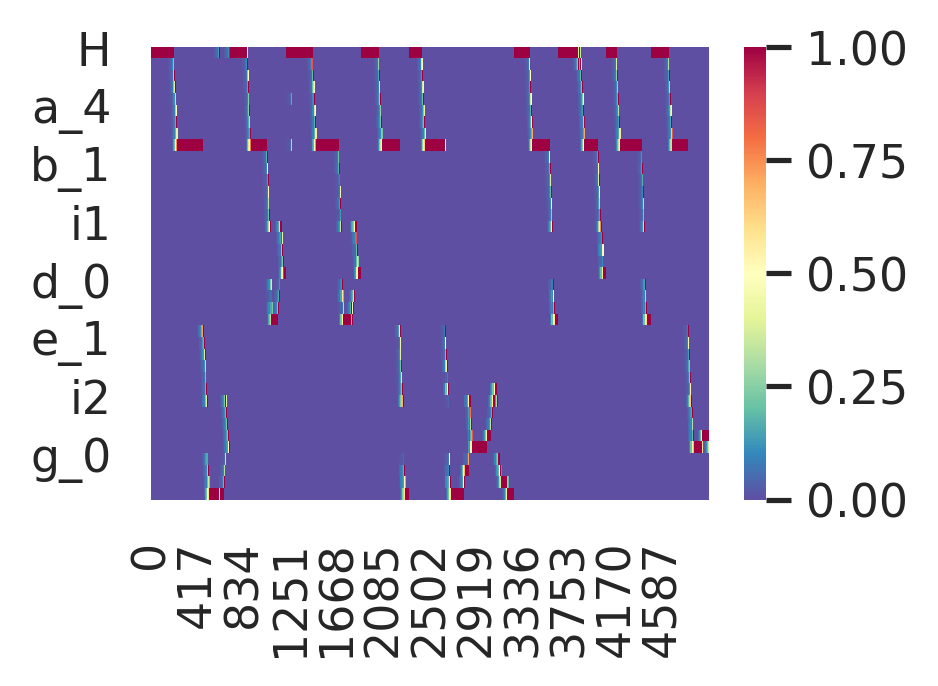

In [667]:
a=ze_lag50.zone_feature_splits['test'][0]
w=5000

f,ax = plt.subplots(figsize=(3,2),dpi=300)
sns.heatmap(a.T.loc[:,:w], cbar=True,robust=True, cmap='Spectral_r')

Text(0.5, 0, 'samples')

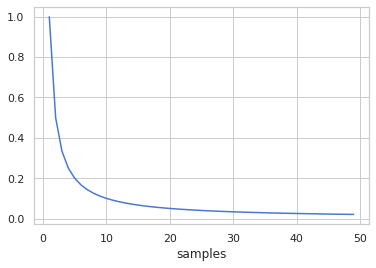

In [659]:
x=np.arange(1,50)
plt.plot(x,1/x)
plt.xlabel('samples')

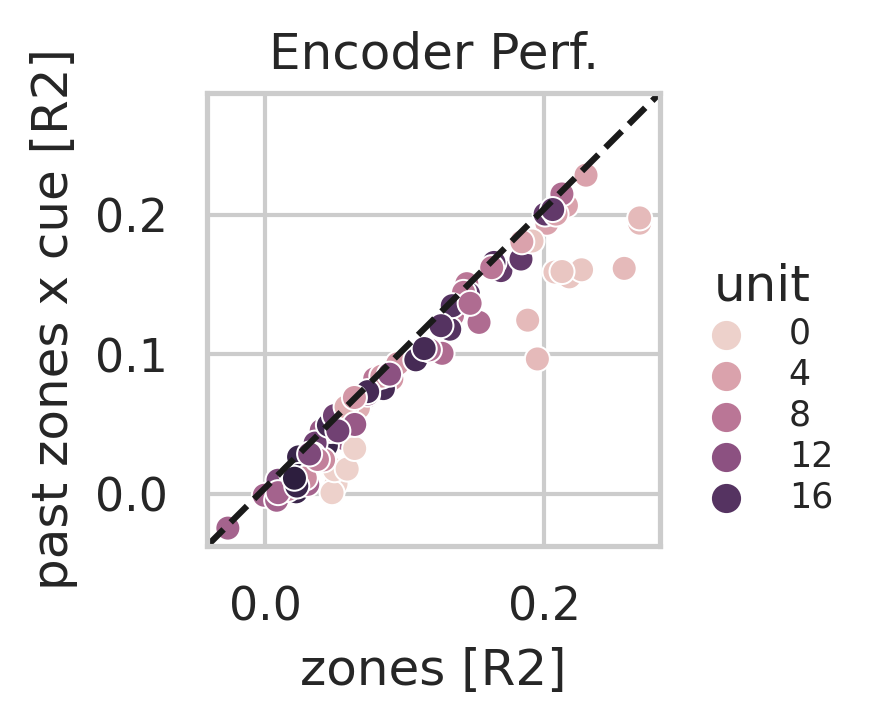

In [620]:
f,ax=plt.subplots(figsize=(2,2),dpi=300)
ax= sns.scatterplot(data=df, x='score',y='cue_lagn50_score', hue='unit', ax=ax)
ax.axis('square')
ax.plot([0,1],[0,1], '--k', transform=ax.transAxes)
ax.set_xlabel('zones [R2]')
ax.set_ylabel('past zones x cue [R2]')
ax.set_title('Encoder Perf.')

ha, la = ax.get_legend_handles_labels()
ax.get_legend().remove()

ax.legend(ha,la,bbox_to_anchor = [1,0,0.2,0.5], loc='lower left', frameon=False, fontsize='small', markerscale=1, labelspacing=0.2,title='unit')

In [611]:
df.max()

unit                     19
split                  test
fold                      4
metric                   r2
score              0.268432
cue_score          0.268024
cue_lag50_score    0.333263
dtype: object

# Decoder Models

In [33]:
tmf = reload(tmf)
de = tmf.ZoneDecoder(ze)
tmz = tmf.TreeMazeZones()

In [34]:
%%time
de.get_decoder_model_fit()

CPU times: user 1min 43s, sys: 167 ms, total: 1min 43s
Wall time: 1min 34s


In [35]:
%%time 
d = de.get_zone_perf_table()

CPU times: user 25.6 s, sys: 496 ms, total: 26.1 s
Wall time: 2.62 s


In [36]:
def get_table_subselection(table, selections):
    
    table2 = table.copy()
    
    for k,v in selections.items():
        table2 = table2[table2[k]==v]
    return table2 

def plot_mean_decoder_perf_by_zone(table, metric='acc', ax=None):
    if ax is None:
        f,ax=plt.subplots()
    
    x1 = np.arange(9)
    x2 = np.arange(9, 16)
    x3 = np.arange(16, tmz.max_seq_length+1)
    cols = plt.cm.Paired([8,9,2,3])
    
    stem = tmz.all_zone_goal_seqs['G1'].values[x1]
    ax.plot(x1,table.loc[stem, metric], lw=3, alpha=0.75 , label='stem', color='k')
    
    right = tmz.all_zone_goal_seqs['G1'].values[x2]
    ax.plot(x2, table.loc[right, metric], lw=3, alpha=0.75 , color=tmz.split_colors['right'])
    
    left = tmz.all_zone_goal_seqs['G3'].values[x2]
    ax.plot(x2, table.loc[left, metric], lw=3, alpha=0.75 , color=tmz.split_colors['left'])
    
    for ii, g in enumerate(tmz.goal_wells):
        seq = tmz.all_zone_goal_seqs[g].values[x3]
        perf = table.loc[seq, metric]
        ax.plot(x3,perf, lw=3, alpha=0.75, color=cols[ii], label=g)
    ax.set_xticks([0,8,15,19])
    ax.set_xticklabels(['H', 'D', 'i', 'G'])
    ax.legend()
    ax.set_xlabel('Zone')
    ax.set_ylabel(metric)
    
def plot_mean_decoder_perf_by_zone2(d, ax=None, split='test', metric='acc'):
    if ax is None:
        f,ax=plt.subplots(1,2,figsize=(5,3),dpi=300)
    else:
        assert len(ax)>=2
    
    selections = dict(split = split)
    d2 = get_table_subselection(d,selections)
    mean_table = d2.groupby(['zones', 'feature_type'])[metric].mean()
    mean_table = mean_table.reset_index()
    mean_table = mean_table.set_index('zones')
    
    chance = 1/len(de.target_names)

    plot_mean_decoder_perf_by_zone(mean_table.loc[mean_table.feature_type=='encoder'],ax=ax[0], metric=metric)
    ax[0].set_title(f" modeled neurons ")
    ax[0].set_ylabel(f" {de.train_target_type} decoder {metric}")

    plot_mean_decoder_perf_by_zone(mean_table.loc[mean_table.feature_type=='neural'],ax=ax[1], metric=metric)
    ax[1].set_yticklabels([])
    ax[1].set_ylabel('')

    ax[1].set_title(f" true neurons ")

    if metric == 'acc':
        ax[0].axhline(chance, color='r', linestyle='--', alpha=0.5, lw=1.5, label='chance', zorder=1)
        ax[1].axhline(chance, color='r', linestyle='--', alpha=0.5, lw=1.5, label='chance',zorder=1)
    
        ax[0].set_ylim([-0.05,1.05])
        ax[1].set_ylim([-0.05,1.05]) 
    else:
        max_val = mean_table[metric].max()
        min_val = mean_table[metric].min()
        
        val_range = min_val - abs(min_val)*0.05, max_val + abs(max_val)*0.05
        print(val_range)
        ax[0].set_ylim(val_range)
        ax[1].set_ylim(val_range) 

    ax[0].get_legend().remove()
    ha, la = ax[1].get_legend_handles_labels()
    ax[1].get_legend().remove()

    ax[1].legend(ha,la,bbox_to_anchor = [1,0,0.2,0.5], frameon=False, fontsize='small', markerscale=0.5, labelspacing=0.2)

In [37]:
d

,zones,error_dist,P(Z=z|z),log_odds,w_error_dist,acc,zone_freq,zone_prob,split,fold,feature_type
0,H,750.609493,0.093345,-14.624341,678.798971,0.093529,14990,0.317444,train,0,neural
1,a_0,562.637695,0.168769,-12.743811,511.504966,0.165653,658,0.013934,train,0,neural
2,a_1,507.609143,0.103077,-15.510919,448.211711,0.105263,551,0.011669,train,0,neural
3,a_2,455.149278,0.157386,-13.090739,415.309175,0.154618,498,0.010546,train,0,neural
4,a_3,397.390199,0.203633,-11.390178,355.987868,0.202586,464,0.009826,train,0,neural
...,...,...,...,...,...,...,...,...,...,...,...
775,G3,0.000000,0.996015,5.521276,0.000000,1.000000,843,0.064063,test,4,encoder
776,g_0,0.000000,0.999883,9.049366,0.000000,1.000000,22,0.001672,test,4,encoder
777,g_1,0.000000,0.999492,7.585198,0.000000,1.000000,126,0.009575,test,4,encoder
778,g_2,0.000000,0.998552,6.535999,0.000000,1.000000,154,0.011703,test,4,encoder


In [566]:
%%time
tmf = reload(tmf)
de = tmf.ZoneDecoder(ze)
tmz = tmf.TreeMazeZones()

CPU times: user 349 ms, sys: 4.01 ms, total: 353 ms
Wall time: 351 ms


In [42]:
%%time
for train_target_type in ['cue', 'first_goal', 'zones']:
    de.decoder_setup(train_feature_type='encoder', train_target_type=train_target_type)
    de.get_decoder_model_fit()
    de_zone_table = de.get_zone_perf_table()
    de_table = de.get_perf_table()

CPU times: user 95 µs, sys: 1 µs, total: 96 µs
Wall time: 103 µs


In [70]:
%%time
tmf = reload(tmf)
de_cue = tmf.ZoneDecoder(ze_cue)

CPU times: user 101 ms, sys: 0 ns, total: 101 ms
Wall time: 97.3 ms


In [71]:
%%time
for train_target_type in ['cue', 'first_goal', 'zones']:
    de_cue.decoder_setup(train_feature_type='encoder', train_target_type=train_target_type)
    de_cue.get_decoder_model_fit()
    de_cue_zone_table = de_cue.get_zone_perf_table()
    de_cue_table = de_cue.get_perf_table()

CPU times: user 4min 8s, sys: 2.52 s, total: 4min 11s
Wall time: 2min 10s


In [117]:
%%time
tmf = reload(tmf)
de_cue_lag50 = tmf.ZoneDecoder(ze_cue_lag50)

CPU times: user 116 ms, sys: 3.87 ms, total: 120 ms
Wall time: 118 ms


In [110]:
%%time
for train_target_type in ['cue', 'first_goal', 'zones']:
    de_cue_lag50.decoder_setup(train_feature_type='encoder', train_target_type=train_target_type)
    de_cue_lag50.get_decoder_model_fit()
    de_cue_lag50_zone_table = de_cue_lag50.get_zone_perf_table()
    de_cue_lag50_table = de_cue_lag50.get_perf_table()

CPU times: user 4min 21s, sys: 2.72 s, total: 4min 24s
Wall time: 2min 16s


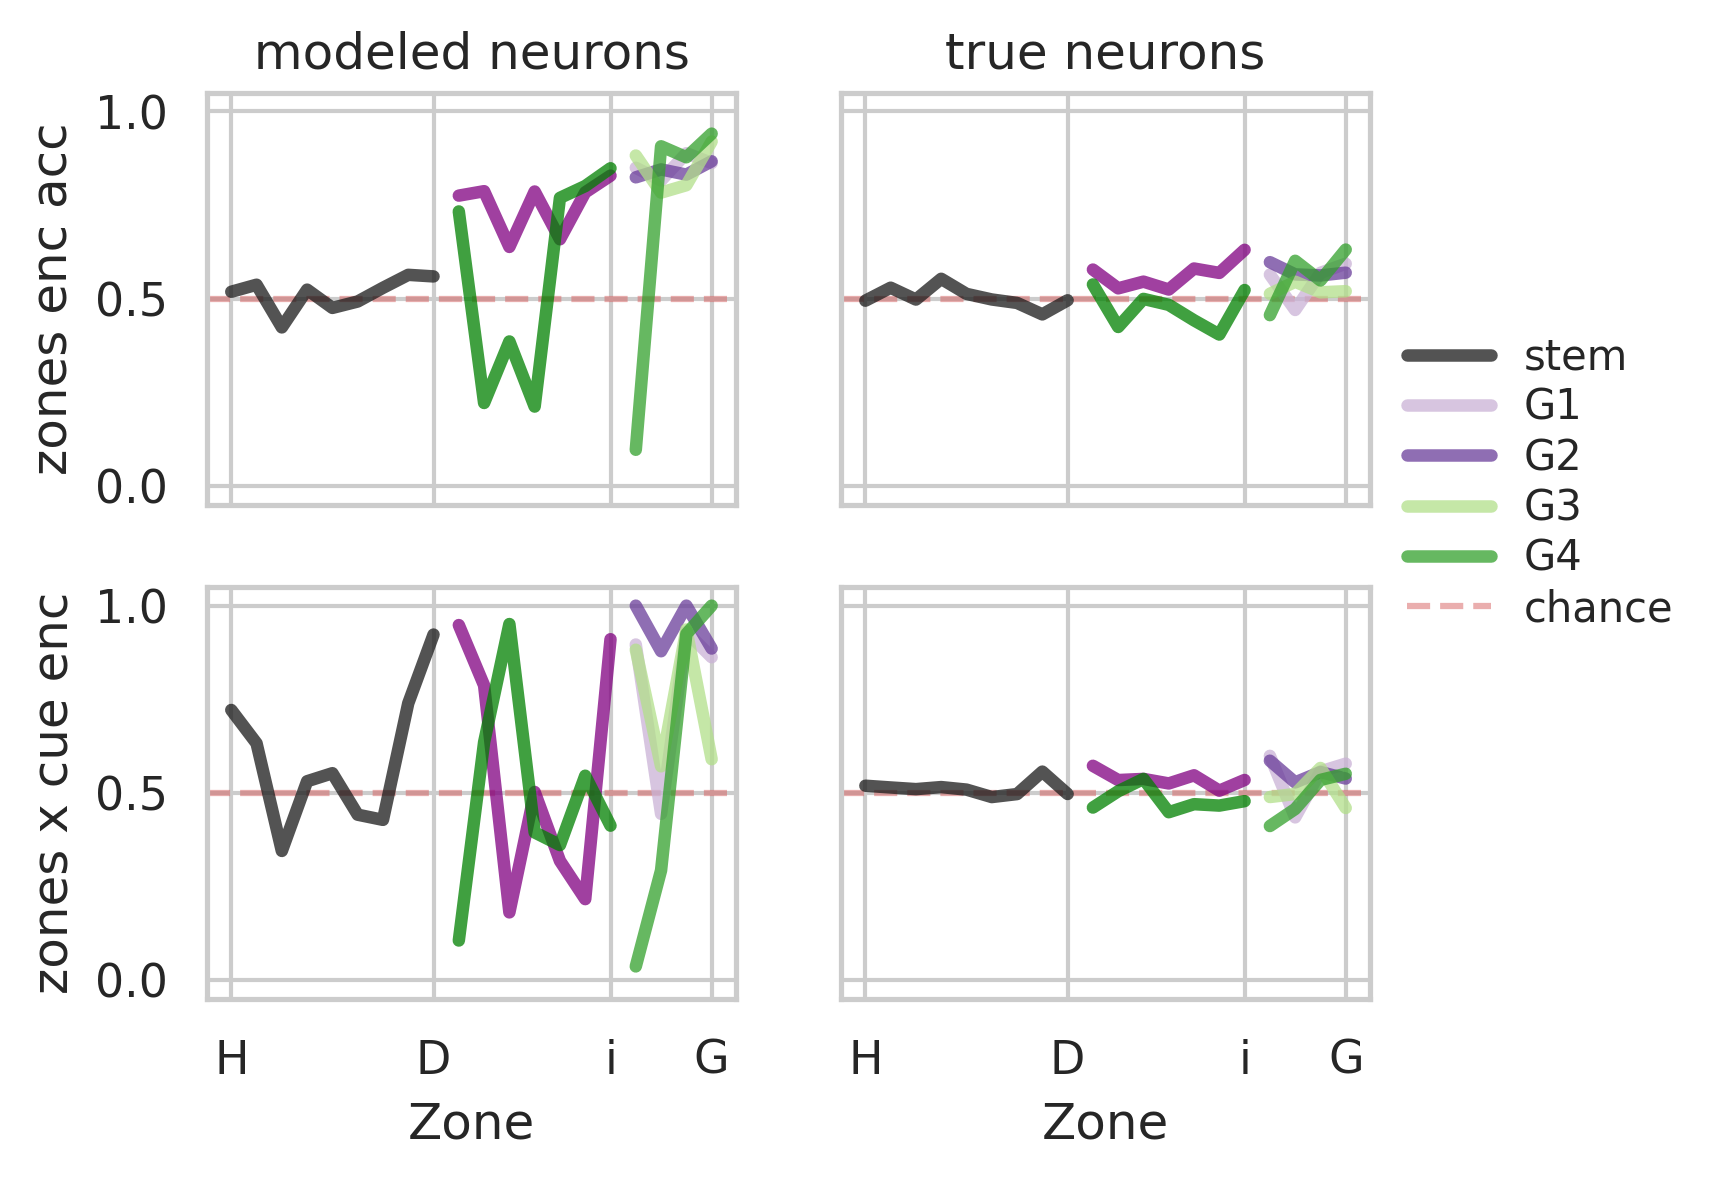

In [62]:
metric = 'acc'
f,ax=plt.subplots(2,2,figsize=(5,4),dpi=300)
plot_mean_decoder_perf_by_zone2(de_zone_table,ax=ax[0], metric=metric)
ax[0,0].set_ylabel('zones enc ' + metric)
ax[0,0].set_xticklabels([])
ax[0,1].set_xticklabels([])
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
plot_mean_decoder_perf_by_zone2(de_cue_zone_table,ax=ax[1], metric=metric)
ax[1,0].set_ylabel('zones x cue enc')
ax[1,0].set_title('')
ax[1,1].set_title('')
ax[1,1].get_legend().remove()
#plot_mean_decoder_perf_by_zone2(d,ax=ax, metric='acc')

In [719]:
%%time
tmf = reload(tmf)
de = tmf.ZoneDecoder(ze)
tmz = tmf.TreeMazeZones()

CPU times: user 343 ms, sys: 10 µs, total: 343 ms
Wall time: 341 ms


In [720]:
%%time
target = 'cue'
de.decoder_setup(feature_type='encoder', target_type=target)
de.get_decoder_model_fit()
de_zone_table = de.get_zone_perf_table()
de_table = de.get_perf_table()

CPU times: user 40.1 s, sys: 732 ms, total: 40.9 s
Wall time: 9 s


In [721]:
de_trial_table=de.get_trial_zone_evidence_table(scoring='logit')

In [722]:
de_trial_table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-4.447030,NaN,-1.014872,-3.156072,-1.185773,NaN,NaN,NaN,-2.669514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-3.032970,NaN,0.571374,NaN,-1.039371,-1.362107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-3.032970,NaN,0.571374,NaN,-1.039371,-1.362107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-3.092849,-1.217745,-0.364900,NaN,NaN,NaN,-1.051265,-1.666101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.359629,NaN,NaN
4,-4.447030,NaN,-1.014872,-3.156072,-1.185773,NaN,NaN,NaN,-2.669514,NaN,0.390022,1.692775,NaN,NaN,0.746703,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,-3.032970,NaN,0.571374,NaN,-1.039371,-1.362107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,-3.032970,NaN,0.571374,NaN,-1.039371,-1.362107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,-3.032970,NaN,0.571374,NaN,-1.039371,-1.362107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,-3.032970,NaN,0.571374,NaN,-1.039371,-1.362107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
%%time
for train_target_type in ['cue', 'first_goal', 'zones']:
    de.decoder_setup(train_feature_type='encoder', train_target_type=train_target_type)
    de.get_decoder_model_fit()
    de_zone_table = de.get_zone_perf_table()
    de_table = de.get_perf_table()

cue ['L', 'R']
first_goal ['G1', 'G2', 'G3', 'G4']
zones ['H', 'a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'a_6', 'D', 'b_0', 'b_1', 'b_2', 'b_3', 'b_4', 'b_5', 'i1', 'c_0', 'c_1', 'c_2', 'G1', 'd_0', 'd_1', 'd_2', 'G2', 'e_0', 'e_1', 'e_2', 'e_3', 'e_4', 'e_5', 'i2', 'f_0', 'f_1', 'f_2', 'G3', 'g_0', 'g_1', 'g_2', 'G4']
CPU times: user 4min 28s, sys: 2.48 s, total: 4min 30s
Wall time: 2min 22s


In [925]:
%%time
tmf = reload(tmf)
target = 'cue'
de_cue = tmf.ZoneDecoder(ze_cue)
de_cue.decoder_setup(feature_type='encoder', target_type=target)
de_cue.get_decoder_model_fit()
de_cue_zone_table = de_cue.get_zone_perf_table()

IndentationError: expected an indented block (tree_maze_functions.py, line 4334)

In [647]:
%%time
for target_type in ['cue', 'first_goal', 'zones']:
    de_cue.decoder_setup(feature_type='encoder', target_type=target_type)
    de_cue.get_decoder_model_fit()
    de_cue_zone_table = de_cue.get_zone_perf_table()

CPU times: user 1min 36s, sys: 810 ms, total: 1min 37s
Wall time: 1min 3s


In [827]:
tmf = reload(tmf)
tmz = tmf.TreeMazeZones()

In [761]:
X2 = {}

In [1354]:
%%time
model = de_cue
target = 'cue'
feature = 'encoder'
model.decoder_setup(feature_type=feature, target_type=target)
model.get_decoder_model_fit()

logit = lambda p: np.log(p/(1-p))
mean_logit =  lambda x: np.mean(logit(x))
split = 'test'
class_target = model.target_classes[0]
grouping = 'pr_target'
estimator = lm.LogisticRegression(fit_intercept=False)

if target in ['cue', 'dec']:
    dist_mat = pd.DataFrame(~np.eye(2, dtype=bool), index=['L', 'R'], columns=['L', 'R'])
    dist_mat = dist_mat.astype(float)
elif target == 'first_goal':
    #assert scoring not in ['acc', 'dist', 'w_dist']
    dist_mat = model.goal_dists
elif target == 'zones':
    #assert scoring not in ['acc', 'dist', 'w_dist']
    dist_mat =model.zone_dists
else:
    raise ValueError
    

zone_names =  tmz.all_zone_sequences.zones2.unique()
all_df = pd.DataFrame()
#X = pd.DataFrame(0, index=range(model.ze.n_trials), columns=zone_names)
for fold_num in range(model.n_folds):
    Y = model.get_targets(fold_num, split)
    Y_hat = model.get_fold_decoder_predictions(fold_num, split)
    Y_prob = model.get_fold_decoder_pred_prob(fold_num, split)
    Z = model.get_fold_zone_ts(fold_num, split)
    Zn = tmz.all_zone_sequences.loc[Z,'zones2'].values.flatten()
    T = model.ze.trial_ts_splits[split][fold_num]

    df = pd.DataFrame(data= np.array((T, Zn, Y)).T, columns=['trial', 'zone', 'target'])
    
    df = pd.concat( (df, Y_prob), axis=1)
    
    df_m = df.groupby(['trial', 'zone', 'target']).mean()
    df_m= df_m.reset_index()
    
    df_m['pred'] = df_m[model.target_classes].idxmax(axis=1)
    df_m['dist'] = dist_mat.lookup(df_m.target, df_m.pred)
    df_m['acc'] = df_m.target==df_m.pred  
    df_m['pr_target'] = df_m.lookup(range(len(df_m)), df_m.target)
    df_m['pr_pred'] = df_m.lookup(range(len(df_m)), df_m.pred)
    df_m['logit_dist'] = logit(df_m.pr_pred)-logit(df_m.pr_target)

    #df_m.drop(columns=model.target_classes, inplace=True)
    df_m = df_m.astype({'acc':float})
    df_m['zone'] = df_m['zone'].astype(pd.api.types.CategoricalDtype(zone_names))
    
    all_df = pd.concat((all_df, df_m))
#     fold_trials = model.ze.xval_trial_table.index[model.ze.xval_trial_table[fold_num]==split]
#     for trial in fold_trials:
#         X.loc[trial] = df_m[df_m.trial==trial][['zone', 'score']].set_index('zone')['score']
# X = X.fillna(0)
# X = X.loc[ze.valid_trials]
#X = X.loc[ze.valid_trials].reset_index(drop=True)

all_df = all_df.reset_index(drop=True)
# C = model.trial_info_table.cue[model.ze.valid_trials].reset_index(drop=True)
# D = model.trial_info_table.dec[model.ze.valid_trials].reset_index(drop=True)

# X2[(feature,target)] = X

CPU times: user 1.83 s, sys: 48.5 ms, total: 1.88 s
Wall time: 196 ms


<timed exec>:46: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
<timed exec>:48: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
<timed exec>:49: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
<timed exec>:46: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
<timed exec>:48: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
<timed exec>:49: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
<tim

<AxesSubplot:xlabel='zone', ylabel='acc'>

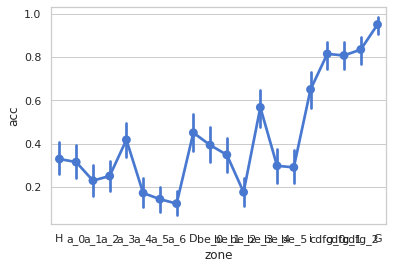

In [1308]:
sns.pointplot(data=all_df, x='zone',y='acc')

In [1271]:
2*logit(0.694408)

1.6416176101557207

<AxesSubplot:xlabel='zone', ylabel='logit_dist'>

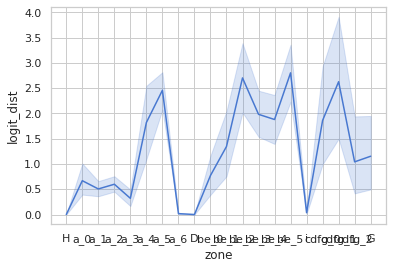

In [1198]:
sns.lineplot(x='zone',y='logit_dist', data=all_df)

<AxesSubplot:xlabel='zone', ylabel='acc'>

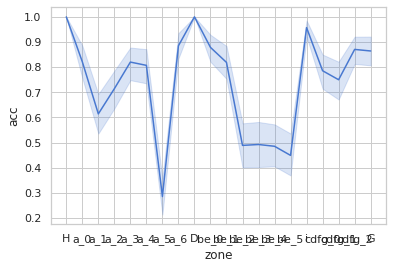

In [1199]:
sns.lineplot(x='zone',y='acc', data=all_df)

In [905]:
%%time
api_X = model.get_trial_zone_evidence_table(scoring=grouping)

CPU times: user 11.9 s, sys: 132 ms, total: 12.1 s
Wall time: 2.51 s


In [781]:
row_colors = C.map(dict(zip(['L','R'], ['#A32CC4','#2E8B57'])))

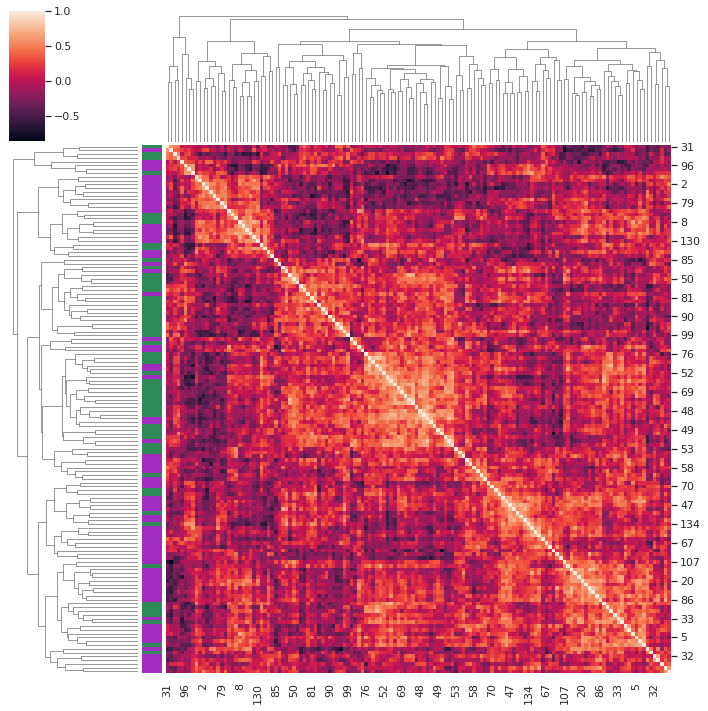

In [865]:
sns.clustermap(np.corrcoef(X2[('neural','cue')]),row_colors=row_colors.values)

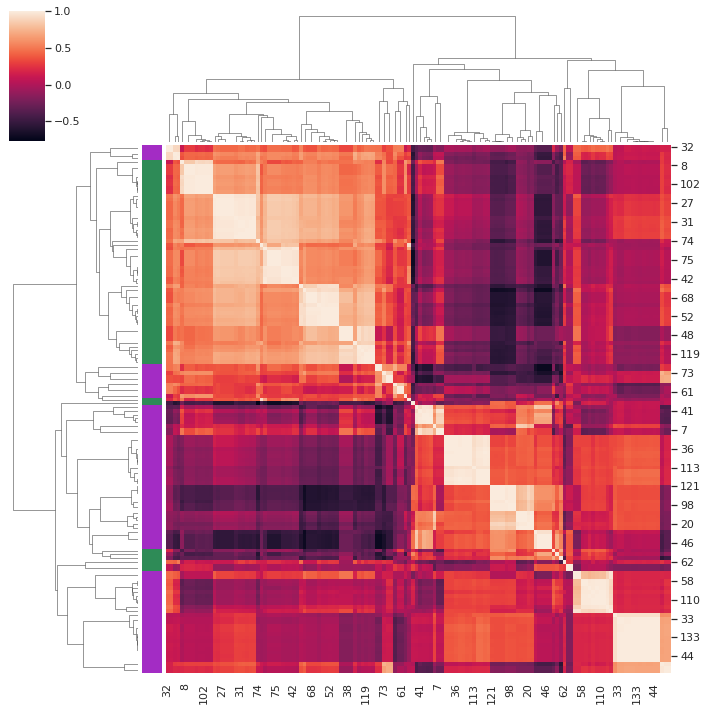

In [866]:
sns.clustermap(np.corrcoef(X2[('encoder','cue')]), row_colors=row_colors.values)

In [927]:
from sklearn.model_selection import cross_val_predict

In [1255]:
pair = ('encoder','cue')

X = all_df.pivot(index='trial', columns='zone', values='L')
X = X.fillna(0)

C = model.trial_info_table.cue[model.ze.valid_trials]
D = model.trial_info_table.dec[model.ze.valid_trials]
G = model.trial_info_table.first_goal[model.ze.valid_trials]

estimator = lm.LogisticRegression(fit_intercept=False)

n_seq = tmz.max_seq_length
zone_names =  X.columns
ydf = pd.DataFrame(np.zeros_like(X), columns=zone_columns)
ydf['trial'] = np.arange(X.shape[0])
ydf['cue'] =  C

for i in range(n_seq):
    XXi = X.loc[:,:zone_names[i]]
    ydf[zone_names[i]] = cross_val_predict(estimator, XXi, C, method='predict_proba')[:,0]
    #sk_metrics.balanced_accuracy_score(C=='L', ydf[zone_columns[i]]>0.5)
#
# 
# bac_d = np.zeros(n_seq)
# for i in range(n_seq):
#     Xi = X.loc[:,:i]
#     bac_c[i] = cross_val_score(estimator, Xi, C, scoring='balanced_accuracy').mean()
#     bac_d[i] = cross_val_score(estimator, Xi, D, scoring='balanced_accuracy').mean()

In [1256]:
ydf2 = ydf.melt(id_vars=['trial', 'cue'], var_name='zone', value_name='P')

In [1265]:
ydf2['acc'] = ((ydf2.P>=0.5) == (ydf2.cue=='L')).astype(float)

<AxesSubplot:xlabel='zone', ylabel='acc'>

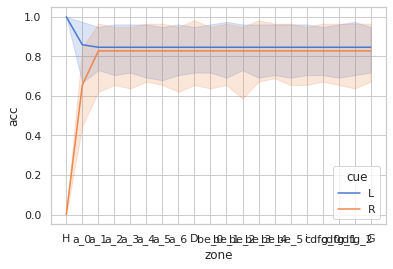

In [1266]:
sns.lineplot(y='acc', x ='zone', hue='cue',data=ydf2, ci=100, markers=True)

<AxesSubplot:xlabel='zone', ylabel='acc'>

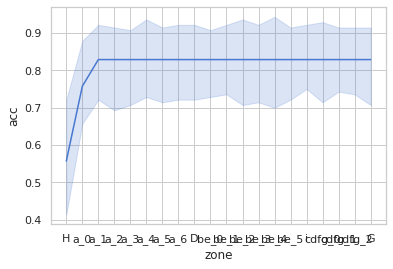

In [1267]:
sns.lineplot(y='acc', x ='zone',data=ydf2, ci=100, markers=True)

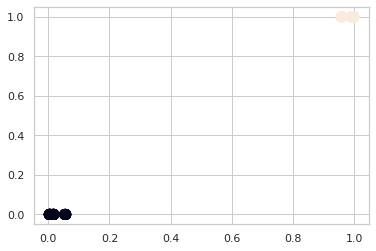

In [811]:
plt.scatter(yp[:,0], C=='L',c=(C=='L')+0.5,lw=5)

In [1285]:
model.target_classes[:-1]

['G1', 'G2', 'G3']

In [1303]:
#all_df.pivot(index='trial', values='target', %colors)

0      G4
1      G2
2      G3
3      G4
4      G2
       ..
139    G1
140    G3
141    G1
142    G2
143    G3
Name: first_goal, Length: 140, dtype: object

In [1409]:
%%time

X = pd.DataFrame()
for target_class in model.target_classes[:-1]:
    X = pd.concat( (X,all_df.pivot(index='trial', columns='zone', values=target_class)), axis=1 )

X = logit(X)
X = X.fillna(0)

estimator = lm.LogisticRegression(fit_intercept=False, class_weight='balanced')

n_seq = tmz.max_seq_length
zone_names = tmz.all_zone_sequences.zones2.unique()

acc_df = pd.DataFrame(0, index=X.index, columns=zone_names)
acc_df['trial'] = X.index
acc_df['target'] = model.trial_info_table[target][model.ze.valid_trials]

prob_df = acc_df.copy()

for fold in range(model.n_folds):
    train_trials = model.ze.get_fold_trials(fold,'train')
    test_trials = model.ze.get_fold_trials(fold,'test')
    
    Ytrain = acc_df.loc[train_trials,'target']
    Ytest = acc_df.loc[test_trials,'target']
    for ii in range(n_seq):
        Xtrain = X.loc[train_trials, zone_names[:(ii+1)]]
        Xtest = X.loc[test_trials, zone_names[:(ii+1)]]

        m = estimator.fit(Xtrain,Ytrain)
        class_idx = m.classes_==model.target_classes[0]
        prob_df.loc[test_trials, zone_names[ii]] = m.predict_proba(Xtest)[:,class_idx]
        
        Ytest_hat = m.predict(Xtest)
        acc_df.loc[test_trials,  zone_names[ii]] = Ytest_hat 
    
prob_df = prob_df.melt(id_vars=['trial', 'target'], var_name='zone', value_name='P')
acc_df = acc_df.melt(id_vars=['trial', 'target'], var_name='zone', value_name='pred')

acc_df['ac'] = (acc_df.target==acc_df.pred).values.astype(float)

fold_idx = (model.ze.xval_trial_table=='test').idxmax(axis=1)
fold_idx = fold_idx.loc[model.ze.valid_trials]
acc_df['fold'] = fold_idx.loc[acc_df.trial].values

acc_df['bac'] = 0
for fold in range(model.n_folds):
    for z in zone_columns:
        idx = (acc_df.zone==z) & (acc_df.fold==fold)
        Y = acc_df[idx].target
        Y_hat = acc_df[idx].pred
        acc_df.loc[idx, 'bac'] = sk_metrics.balanced_accuracy_score(Y, Y_hat)
    
acc_df[f"P({model.target_classes[0]})"] = prob_df['P']

CPU times: user 1.17 s, sys: 42 µs, total: 1.17 s
Wall time: 1.18 s


<AxesSubplot:xlabel='zone', ylabel='bac'>

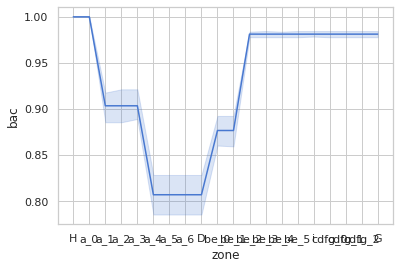

In [ ]:
sns.lineplot(y='bac', x ='zone', data=acc_df, ci=68, markers=True)

<AxesSubplot:xlabel='zone', ylabel='ac'>

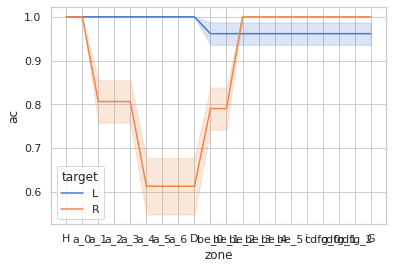

In [1395]:
sns.lineplot(y='ac', x ='zone', hue='target', data=acc_df, ci=68, markers=True)

<AxesSubplot:xlabel='zone', ylabel='ac'>

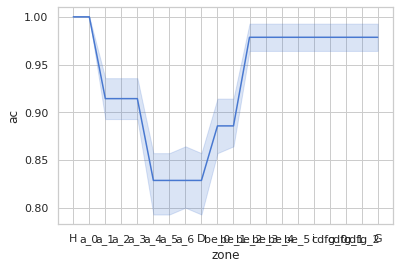

In [1358]:
sns.lineplot(y='ac', x ='zone', data=acc_df, ci=68, markers=True)

In [1344]:
acc_df

,trial,target,zone,pred,ac,bac,P(G1)
0,0,G4,H,G4,1.0,0.440438,4.187635e-02
1,1,G2,H,G4,0.0,0.440438,6.051627e-02
2,2,G3,H,G4,0.0,0.440438,6.051627e-02
3,3,G4,H,G4,1.0,0.440438,2.817966e-02
4,4,G2,H,G4,0.0,0.440438,4.187635e-02
...,...,...,...,...,...,...,...
2795,135,G1,G,G1,1.0,0.899510,9.886049e-01
2796,136,G3,G,G3,1.0,0.899510,5.183518e-15
2797,137,G1,G,G1,1.0,0.899510,9.597948e-01
2798,138,G2,G,G2,1.0,0.899510,5.858311e-03


<AxesSubplot:xlabel='zone', ylabel='P(L)'>

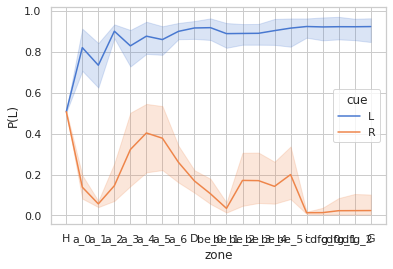

In [1225]:
sns.lineplot(y='P(L)', x ='zone', hue='cue',data=acc_df, ci=100, markers=True)

In [955]:
m.predict_proba(Xtest)[:,0]

array([7.36377884e-01, 9.92656934e-01, 9.78941162e-02, 9.90862024e-01,
       8.55249018e-02, 9.78941162e-02, 9.89698243e-01, 9.34473013e-01,
       9.89698243e-01, 9.92323160e-01, 8.79206462e-02, 9.95414265e-01,
       9.78941162e-02, 7.76315055e-05, 9.34473013e-01, 9.95571312e-01,
       8.45940319e-02, 8.17598990e-02, 9.92913931e-01, 8.01089259e-01,
       9.93745168e-01, 9.93391957e-01, 9.93645104e-01, 5.65725333e-02,
       6.13154211e-02, 8.29074595e-02, 5.65725333e-02])

([<matplotlib.axis.XTick at 0x7f3cea4062e0>,
 [Text(0, 0, 'H'), Text(8, 0, 'D'), Text(15, 0, 'i'), Text(19, 0, 'G')])

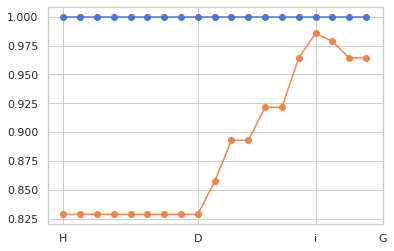

In [364]:
plt.plot(range(n_seq),np.array((bac_c,bac_d)).T, marker='o')
plt.xticks([0,8,15,19],labels=['H','D','i','G'])

In [366]:
np.mean(C==D)

8.285714285714286e-01

In [326]:
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score

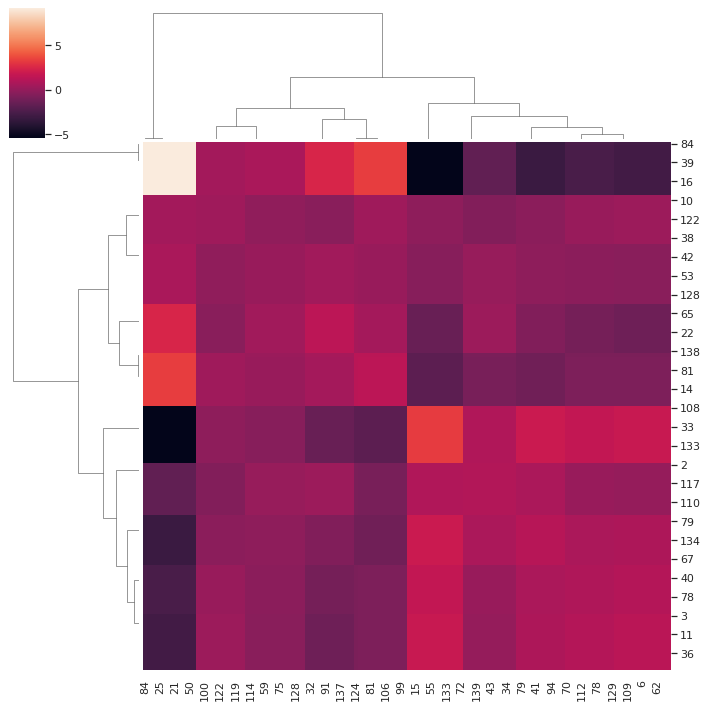

In [298]:
sns.clustermap(Xpc@Xpc.T)

In [301]:
m = sm.Logit(C==target, X).fit()
m.summary()

         Current function value: 0.425807
         Iterations: 35


/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    cue   No. Observations:                  140
Model:                          Logit   Df Residuals:                      122
Method:                           MLE   Df Model:                           17
Date:                Tue, 15 Feb 2022   Pseudo R-squ.:                  0.3798
Time:                        10:23:26   Log-Likelihood:                -59.613
converged:                      False   LL-Null:                       -96.124
Covariance Type:            nonrobust   LLR p-value:                 6.466e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0            317.8059   4.25e+08   7.48e-07      1.000   -8.32e+08    8.32e+08
1            528.0889        nan        nan        nan         nan         nan
2            745.9466        nan        nan        nan         nan         nan
3            448.6047        nan        nan        nan         nan         nan
4            297.9081        nan        nan        nan         nan         nan
5            535.6717        nan        nan        nan         nan         nan
6            192.3199        nan        nan        nan         nan         nan
7            113.8041   1.94e+04      0.006      0.995    -3.8e+04    3.82e+04
8           -424.6447        nan        nan        nan         nan         nan
9              0.8310      0.859      0.968      0.333      -0.852       2.514
10             0.7294      0.570      1.281      0.200      -0.387       1.846
11            -0.0875      1.438     -0.061      0.951      -2.906       2.731
12            -0.6381      0.712     -0.896      0.370      -2.034       0.758
13             0.5182      0.468      1.107      0.268      -0.399       1.435
14             1.0149      0.836      1.214      0.225      -0.623       2.653
15            -1.0234      1.364     -0.750      0.453      -3.697       1.650
16            -0.1791      0.328     -0.546      0.585      -0.822       0.463
17            -0.1096      0.460     -0.238      0.812      -1.012       0.792
18             0.4504      0.910      0.495      0.620      -1.332       2.233
==============================================================================
"""

In [346]:
?plt.xticks

Signature: plt.xticks(ticks=None, labels=None, **kwargs)
Docstring:
Get or set the current tick locations and labels of the x-axis.

Pass no arguments to return the current values without modifying them.

Parameters
----------
ticks : array-like, optional
    The list of xtick locations.  Passing an empty list removes all xticks.
labels : array-like, optional
    The labels to place at the given *ticks* locations.  This argument can
    only be passed if *ticks* is passed as well.
**kwargs
    `.Text` properties can be used to control the appearance of the labels.

Returns
-------
locs
    The list of xtick locations.
labels
    The list of xlabel `.Text` objects.

Notes
-----
Calling this function with no arguments (e.g. ``xticks()``) is the pyplot
equivalent of calling `~.Axes.get_xticks` and `~.Axes.get_xticklabels` on
the current axes.
Calling this function with arguments is the pyplot equivalent of calling
`~.Axes.set_xticks` and `~.Axes.set_xticklabels` on the current axes.

Exam

In [340]:
tmz.all_zone_sequences.n.isin([0,8,15,19])

H       True
a_0    False
a_1    False
a_2    False
a_3    False
a_4    False
a_5    False
a_6    False
D       True
b_0    False
b_1    False
b_2    False
b_3    False
b_4    False
b_5    False
i1      True
c_0    False
c_1    False
c_2    False
G1      True
d_0    False
d_1    False
d_2    False
G2      True
e_0    False
e_1    False
e_2    False
e_3    False
e_4    False
e_5    False
i2      True
f_0    False
f_1    False
f_2    False
G3      True
g_0    False
g_1    False
g_2    False
G4      True
Name: n, dtype: bool

In [313]:
sk_metrics.balanced_accuracy_score(m.predict(X),C)

0.8285714285714285

In [178]:
df = pd.DataFrame(data= np.array((Z, Y, trial)).T, columns=['zone', 'target', 'trial'])
df = pd.concat( (df,Y_prob), axis=1)

In [187]:
foo =  lambda x: np.mean(np.log(x/(1-x)))
x = df.groupby(['zone','target', 'trial']).apply(foo)
x = x.reset_index()

<AxesSubplot:>

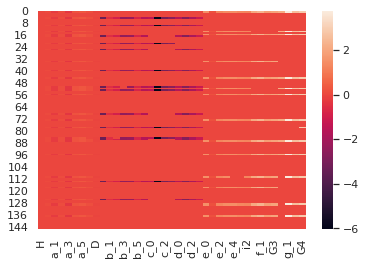

In [207]:

for trial in range(ze.n_trials):
    X.loc[trial] = x[(x.trial==trial)][ ['zone']+de.target_names].set_index('zone')['L']
sns.heatmap(X.fillna(0))

In [213]:
ze.xval_trial_table.index[ze.xval_trial_table[fold_num]=='test']

Int64Index([  0,   4,   9,  13,  15,  16,  21,  25,  33,  39,  44,  50,  51,
             52,  55,  68,  72,  77,  84,  85,  86,  95, 110, 113, 117, 125,
            128, 129, 136],
           dtype='int64')

In [204]:
trial=0
x[(x.trial==trial)][ ['zone']+de.target_names].set_index('zone')['L']

zone
D     -0.062221
G3     1.972085
G4     2.884816
H     -0.012573
a_0    0.048014
a_1   -0.238786
a_2    0.091555
a_3   -0.347936
a_4    0.227819
a_5    0.299396
a_6    0.124841
e_0    1.488209
e_1    0.169419
e_2    1.261960
e_3    1.442376
e_4    1.481229
e_5    1.310611
f_0    2.069503
f_1    2.332220
f_2    1.807843
g_0    2.149563
g_1    3.732883
g_2    2.594954
i2     1.259930
Name: L, dtype: float64

(array(['L', 'R'], dtype='<U32'), ['L', 'R'])

In [92]:
de.get_fold_zone_perf_table(0,'test')

KeyError: "None of [Index(['L', 'R'], dtype='object')] are in the [columns]"

In [134]:
Y

array(['H', 'H', 'H', ..., 'G4', 'G4', 'G4'], dtype=object)

In [116]:
de_cue_lag50.decoder_model_fit[0].classes_, de_cue_lag50.target_names

(array(['D', 'G1', 'G2', 'G3', 'G4', 'H', 'a_0', 'a_1', 'a_2', 'a_3',
        'a_4', 'a_5', 'a_6', 'b_0', 'b_1', 'b_2', 'b_3', 'b_4', 'b_5',
        'c_0', 'c_1', 'c_2', 'd_0', 'd_1', 'd_2', 'e_0', 'e_1', 'e_2',
        'e_3', 'e_4', 'e_5', 'f_0', 'f_1', 'f_2', 'g_0', 'g_1', 'g_2',
        'i1', 'i2'], dtype=object),
 ['L', 'R'])

In [104]:
de.feature_target_pairs

[('encoder', 'encoder'),
 ('encoder', 'zones'),
 ('encoder', 'cue'),
 ('encoder', 'first_goal')]

In [97]:
Y_hat

array(['G3', 'G3', 'G3', ..., 'G4', 'G4', 'G4'], dtype='<U32')

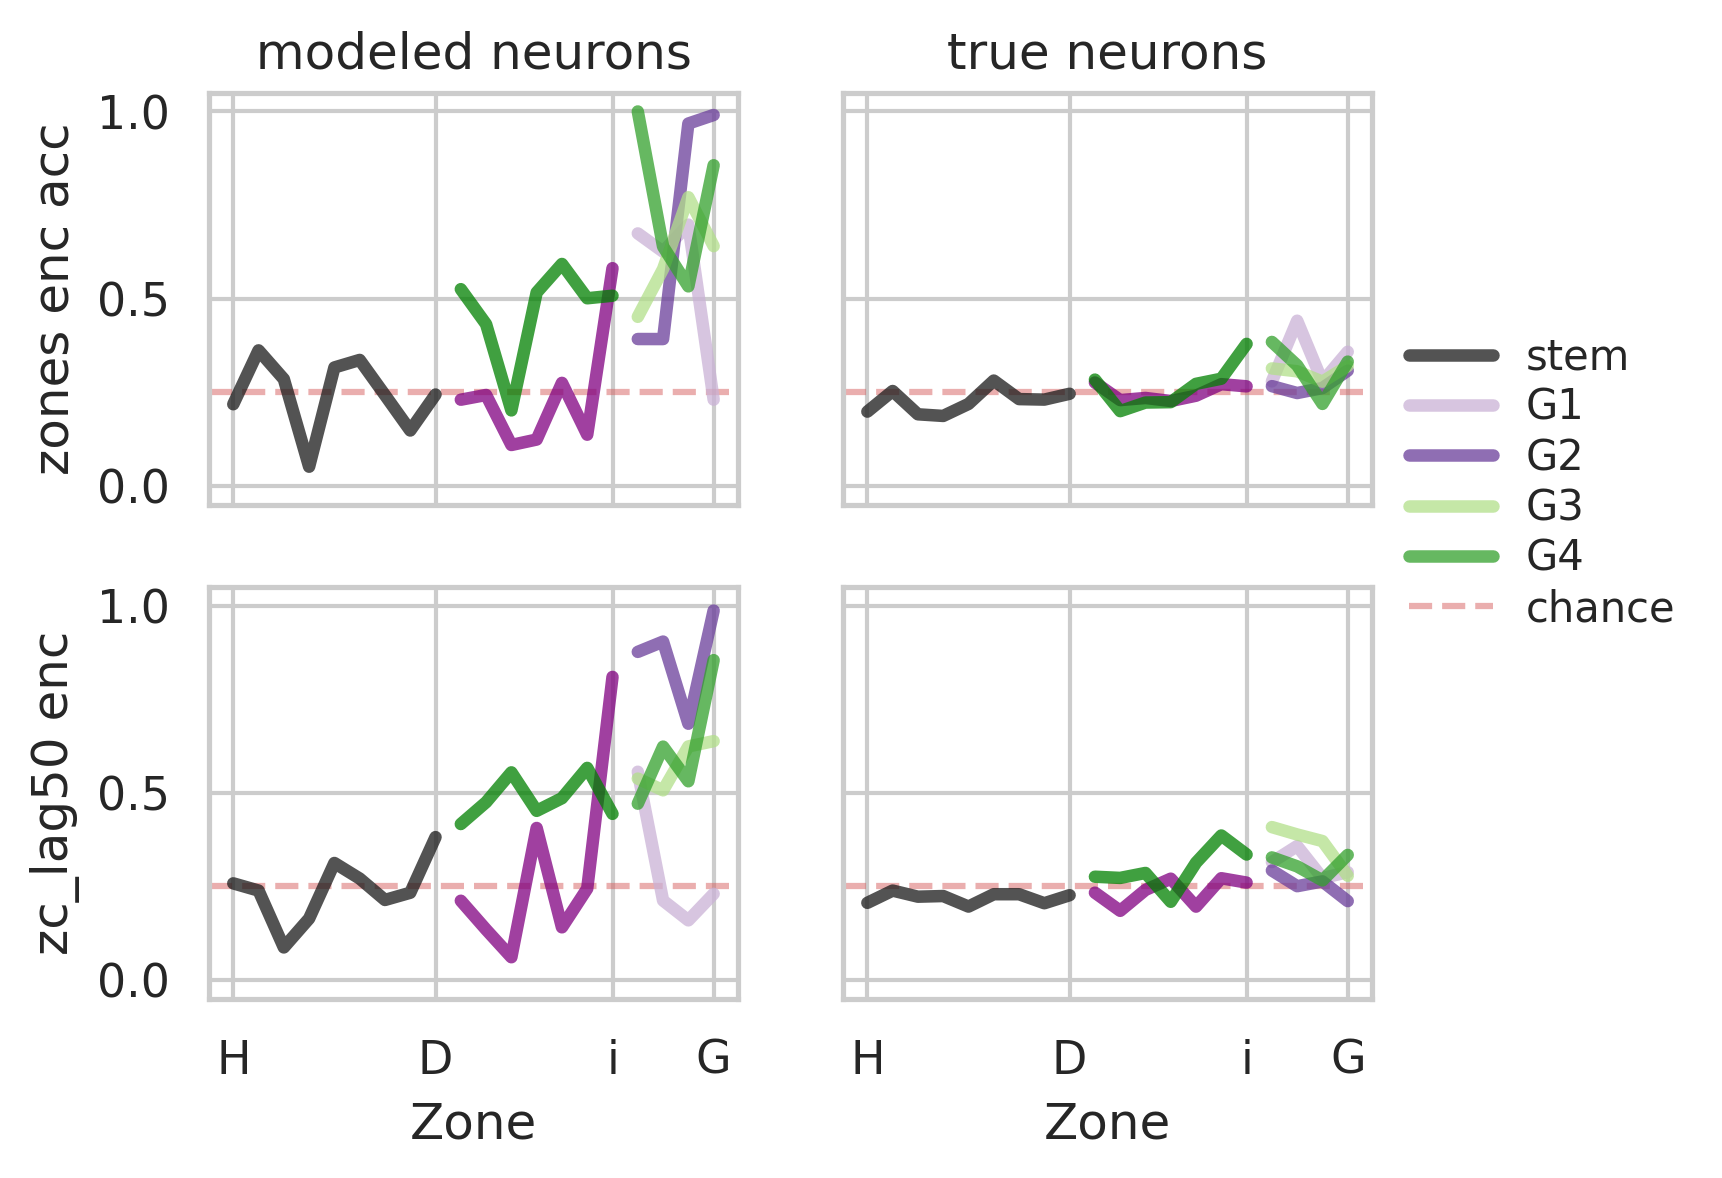

In [86]:
metric = 'acc'
f,ax=plt.subplots(2,2,figsize=(5,4),dpi=300)
plot_mean_decoder_perf_by_zone2(de_zone_table,ax=ax[0], metric=metric)
ax[0,0].set_ylabel('zones enc ' + metric)
ax[0,0].set_xticklabels([])
ax[0,1].set_xticklabels([])
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
plot_mean_decoder_perf_by_zone2(de_cue_lag50_zone_table,ax=ax[1], metric=metric)
ax[1,0].set_ylabel('zc_lag50 enc')
ax[1,0].set_title('')
ax[1,1].set_title('')
ax[1,1].get_legend().remove()

In [573]:
d.groupby(['zones', 'split', 'feature_type']).mean().reset_index()

,zones,split,feature_type,error_dist,P(Z=z|z),log_odds,w_error_dist,acc,zone_freq,zone_prob,fold
0,D,test,encoder,NaN,NaN,NaN,NaN,0.243968,3531.4,0.251942,2.0
1,D,test,neural,NaN,NaN,NaN,NaN,0.246143,3531.4,0.251942,2.0
2,D,train,encoder,NaN,NaN,NaN,NaN,0.218610,12063.8,0.253723,2.0
3,D,train,neural,NaN,NaN,NaN,NaN,0.245254,12063.8,0.253723,2.0
4,G1,test,encoder,NaN,NaN,NaN,NaN,0.230270,214.8,0.015286,2.0
...,...,...,...,...,...,...,...,...,...,...,...
151,i1,train,neural,NaN,NaN,NaN,NaN,0.267058,949.2,0.019962,2.0
152,i2,test,encoder,NaN,NaN,NaN,NaN,0.507899,239.6,0.017025,2.0
153,i2,test,neural,NaN,NaN,NaN,NaN,0.379247,239.6,0.017025,2.0
154,i2,train,encoder,NaN,NaN,NaN,NaN,0.472559,773.6,0.016268,2.0


In [555]:
fold = 3
sorted_targets = sorted(de.target_names)

Y = de.get_targets(fold, split)
Y_hat = de.get_fold_decoder_predictions(fold, split, feature_type)
Y_prob = de.get_fold_decoder_pred_prob(fold, split, feature_type)
Y_prob = Y_prob[sorted_targets]

target_n_samps = pd.Series(Y).value_counts()
target_prob = target_n_samps / target_n_samps.sum()

In [561]:
sk_metrics.roc_auc_score(Y, Y_prob, multi_class='ovo', labels=sorted_targets)
sk_metrics.log_loss(Y, Y_prob, labels=sorted_targets)

1.1430963433199381

In [427]:
metric='w_error_dist'
split='test'
selections = dict(split = split)
d2 = get_table_subselection(d,selections)
mean_table = d2.groupby(['zones', 'feature_type'])[metric].mean()
mean_table = mean_table.reset_index()
mean_table = mean_table.set_index('zones')


In [430]:
#mean_table[metric].min(),mean_table[metric].max()
mean_table.loc[mean_table.feature_type=='neural']

,feature_type,w_error_dist
zones,,
D,neural,0.027931
G1,neural,0.048432
G2,neural,0.133646
G3,neural,0.049779
G4,neural,0.570951
H,neural,0.013554
a_0,neural,0.013851
a_1,neural,0.205610
a_2,neural,0.165343


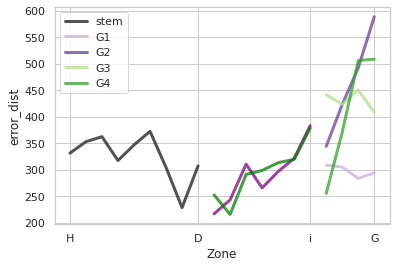

In [409]:
plot_mean_decoder_perf_by_zone(mean_table.loc[mean_table.feature_type=='neural'], metric=metric)

In [531]:
fold=0
split='test'
Y = de.get_targets(fold,split)
Y_hat = de.get_fold_decoder_predictions(fold, split)
Y_prob = de.get_fold_decoder_pred_prob(fold,split) 
Z = de.get_fold_zone_ts(fold,split)

In [537]:
pd.Series(Y).value_counts()[sorted(de.target_names)]

G1     429
G2    6449
G3    2934
G4    4929
dtype: int64

In [491]:
%%time
Y_prob_dummy = np.ones_like(Y_prob)@np.diag(d.zone_prob[sorted(de.target_names)])
sk_metrics.log_loss(Y, Y_prob_dummy)

CPU times: user 939 ms, sys: 8.16 ms, total: 947 ms
Wall time: 97.3 ms


2.4543266377999275

In [708]:
%%time
de_cue.decoder_setup(train_feature_type='encoder', train_target_type='zones')
de_cue.get_decoder_model_fit()
de_cue_zone_table = de_cue.get_zone_perf_table()
de_cue_table = de_cue.get_perf_table()

CPU times: user 66 µs, sys: 0 ns, total: 66 µs
Wall time: 73.2 µs


In [696]:
de_cue_zone_table = de_cue.get_zone_perf_table()
de_cue_table = de_cue.get_perf_table()

<AxesSubplot:>

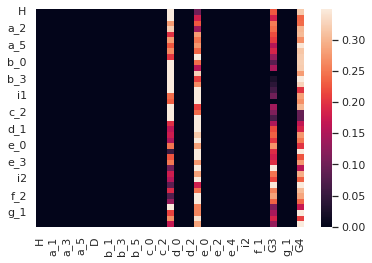

In [709]:

sns.heatmap(de_cue.get_confusion_mat(), robust=True)

In [704]:
de_cue.get_fold_decoder_predictions(0,'test')

array(['G1', 'G1', 'G1', ..., 'G2', 'G2', 'G4'], dtype='<U32')

In [710]:
de_cue.decoder_model_fit[0].classes_

array(['G1', 'G2', 'G3', 'G4'], dtype='<U32')

In [717]:
de_cue.all_pairs_fit[('encoder', 'cue')][0].classes_

array(['G1', 'G2', 'G3', 'G4'], dtype='<U32')

[('encoder', 'encoder'),
 ('encoder', 'zones'),
 ('encoder', 'cue'),
 ('encoder', 'first_goal')]

In [495]:
%%time
lld=-d.zone_prob@np.log(d.zone_prob)

CPU times: user 1 ms, sys: 7 µs, total: 1.01 ms
Wall time: 1.03 ms


In [497]:
1-ll/lld

0.3338852356196952

In [195]:
dist_mat = tmz.all_zone_dists
dists = dist_mat.lookup(Z, Y_hat)
prob_correct_zone = Y_prob.lookup(np.arange(len(Y)), Y)
prob_predicted_zone = Y_prob.lookup(np.arange(len(Y)), Y_hat)

/tmp/ipykernel_16196/2862311045.py:2: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  dists = dist_mat.lookup(Z, Y_hat)
/tmp/ipykernel_16196/2862311045.py:3: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  prob_correct_zone = Y_prob.lookup(np.arange(len(Y)), Y)
/tmp/ipykernel_16196/2862311045.py:4: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  prob_predicted_zone = Y_prob.lookup(np.arange(len(Y)), Y_hat)


In [197]:
log_odds = np.log(prob_correct_zone / (1 - prob_correct_zone))
prob_w_dist = dists * prob_predicted_zone

dist_table = pd.DataFrame(data=np.array((Z, dists, prob_correct_zone, log_odds, prob_w_dist)).T,
                          index=range(len(Y)),
                          columns=['zones', 'error_dist', 'P(Z=z|z)', 'log_odds', 'w_error_dist'])


In [203]:
dist_m_table = dist_table.groupby('zones').mean()

In [703]:
fits = de.decoder_model_fit

In [708]:
de.decoder_model_fit = fits

In [41]:
df = pd.DataFrame()

for feature_type in de.train_feature_types:
    for split in ['train', 'test']:
        for fold in range(de.n_folds):
            d = de.get_fold_zone_perf_table(fold, split, feature_type)
            d = d.reset_index()
            d['split'] = split
            d['fold'] = fold
            d['feature_type'] = 'neural'
            df = pd.concat( (df,d) )
            
df = df.reset_index(drop=True)

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/tree_maze_functions.py:4084: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  dists = dist_mat.lookup(Y, Y_hat)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/tree_maze_functions.py:4086: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  prob_correct_zone = Y_prob.lookup(np.arange(len(Y)), Y)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/tree_maze_functions.py:4087: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  prob_predicted_zone = Y_prob.lookup(np.arange(len(Y)), Y_hat)
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/tree_maze_functions.py:4084: FutureWarning: The 'lookup' method is deprecated and wi

In [42]:
metrics = ['balanced_accuracy', 'log_loss']
pd.DataFrame()
for feature_type in de.feature_types:
    for split in ['train', 'test']:
        for fold in range(1, de.n_folds):
            Y = de.get_targets(fold, split)
            Y_hat = de.get_fold_decoder_predictions(fold, split, feature_type)
            Y_prob = de.get_fold_decoder_pred_prob(fold, split, feature_type)
            

,zones,error_dist,P(Z=z|z),log_odds,w_error_dist,acc,zone_freq,zone_prob,split,fold,feature_type
0,H,753.720984,0.093729,-7.266290,679.098486,0.094596,14990,0.317444,train,0,neural
1,a_0,569.025740,0.161981,-6.325551,517.345923,0.162614,658,0.013934,train,0,neural
2,a_1,522.471843,0.100688,-7.395025,460.394670,0.101633,551,0.011669,train,0,neural
3,a_2,454.227819,0.153772,-6.476569,413.372195,0.152610,498,0.010546,train,0,neural
4,a_3,401.024761,0.200660,-5.772313,360.688611,0.200431,464,0.009826,train,0,neural
...,...,...,...,...,...,...,...,...,...,...,...
775,G3,0.000000,0.992887,4.938701,0.000000,1.000000,843,0.064063,test,4,neural
776,g_0,0.000000,0.996214,5.572625,0.000000,1.000000,22,0.001672,test,4,neural
777,g_1,0.000000,0.995974,5.511032,0.000000,1.000000,126,0.009575,test,4,neural
778,g_2,0.000000,0.995249,5.344627,0.000000,1.000000,154,0.011703,test,4,neural


In [45]:
x =  {('a','b'):2}
x

{('a', 'b'): 2}

In [34]:
d.w_error_dist@d.zone_prob, d.acc@d.zone_prob

(471.15376264237136, 0.11199888834850275)

In [773]:
Y_prob = de.get_fold_decoder_pred_prob(0, 'train')
Y_prob

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,2.211217e-04,4.596118e-08,2.140246e-07,9.618449e-04,5.809603e-10,3.247839e-21,6.677134e-09,9.854703e-01,7.782302e-07,3.184271e-18,...,3.778575e-08,3.801056e-15,1.893800e-10,8.746574e-07,2.530995e-04,3.430053e-03,2.915494e-26,9.789857e-14,5.128717e-09,1.807103e-07
1,4.637964e-04,4.046372e-09,4.611048e-13,4.746954e-06,3.996046e-11,1.746370e-22,1.187965e-09,1.858713e-02,1.272358e-07,2.537538e-21,...,9.833649e-17,5.858976e-22,7.756574e-12,5.987644e-06,2.862131e-06,9.806030e-01,1.420396e-27,6.322136e-15,8.266854e-08,1.256566e-07
2,2.596863e-02,4.245931e-07,3.980092e-15,3.454296e-10,1.613214e-12,9.392085e-16,5.758523e-07,3.859127e-03,1.844581e-07,1.140159e-19,...,4.815781e-19,8.592027e-23,1.884732e-08,2.410829e-04,7.624880e-09,9.698931e-01,6.960445e-30,9.568266e-15,9.460481e-08,2.461634e-08
3,9.869458e-01,1.420389e-05,1.468688e-16,8.446311e-14,1.630506e-14,8.287968e-11,1.277050e-03,6.087355e-04,1.681026e-07,1.635519e-10,...,2.245660e-20,5.092373e-22,2.422217e-06,2.554939e-03,8.971926e-11,3.174323e-03,9.466870e-31,1.924299e-13,2.279634e-07,1.095877e-08
4,1.686718e-02,3.127466e-08,3.728654e-20,2.175325e-16,2.685142e-18,1.297272e-14,1.671104e-04,1.849749e-08,1.025740e-10,4.348624e-02,...,1.175673e-25,2.863031e-24,1.443847e-10,2.933481e-05,3.499111e-13,5.366305e-08,1.239677e-30,2.953726e-13,5.451779e-08,4.542419e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56818,1.540913e-20,7.861285e-06,4.808173e-14,1.476057e-15,8.803295e-32,3.466504e-20,1.060141e-10,4.658312e-07,9.758190e-19,9.999687e-01,...,2.527757e-17,3.339910e-19,2.395531e-15,3.032814e-11,1.007026e-18,5.142133e-25,4.332420e-37,4.293195e-30,1.360474e-18,1.536200e-19
56819,9.330175e-25,9.451422e-17,6.172203e-21,1.260151e-17,1.465931e-32,1.622095e-24,2.345690e-14,1.209440e-11,1.222051e-21,1.000000e+00,...,1.839349e-26,1.598878e-26,2.383292e-19,9.683263e-17,5.807011e-21,3.499193e-26,2.644637e-40,1.337183e-34,1.038865e-22,9.144704e-23
56820,4.851846e-26,4.826909e-23,5.262259e-26,8.583466e-19,1.537910e-32,1.742097e-31,3.274788e-19,6.735023e-16,1.346372e-24,1.000000e+00,...,4.781098e-34,2.695726e-32,3.817005e-26,4.618036e-23,2.102394e-22,8.760095e-28,2.051629e-36,1.133572e-33,6.665773e-24,1.205883e-23
56821,4.279891e-24,2.371723e-20,8.192545e-27,1.565976e-19,5.132006e-33,1.658435e-38,5.325917e-23,4.156555e-17,6.254316e-26,1.000000e+00,...,8.645799e-37,2.173000e-34,9.056912e-32,2.038136e-26,2.557583e-22,8.751637e-28,3.112837e-35,4.797690e-29,5.305039e-22,2.337709e-21


## Cross encoder decomposition attempt.

In [628]:
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA, PLSSVD
from sklearn.decomposition import PCA

In [629]:
fold = 3
split = 'train'

Xtr = ze.zone_feature_splits[split][fold]
Ytr = ze.response_splits[split][fold]
Xte = ze.zone_feature_splits['test'][fold]
Yte = ze.response_splits['test'][fold]

ze.get_model_fits()

{0: LinearRegression(fit_intercept=False),
 1: LinearRegression(fit_intercept=False),
 2: LinearRegression(fit_intercept=False),
 3: LinearRegression(fit_intercept=False),
 4: LinearRegression(fit_intercept=False)}

In [630]:
%%time
#m = PLSCanonical(algorithm='svd', n_components=2, scale=True).fit(Xtr,Ytr)
#m = PLSRegression(n_components=2, scale=True).fit(Xtr,Ytr)
m = CCA(n_components=2, scale=True).fit(Xtr,Ytr)

CPU times: user 2.09 s, sys: 68.1 ms, total: 2.16 s
Wall time: 271 ms


<AxesSubplot:>

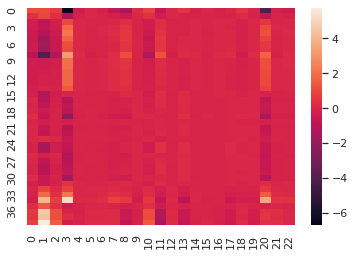

In [631]:
sns.heatmap(m.coef_)

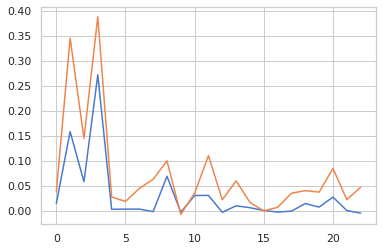

In [632]:
Yte_hat = m.predict(Xte)
Yte_hat_lm = ze.get_fold_prediction(fold, 'test')
plt.plot(rs.get_r2(Yte.T,Yte_hat.T))
plt.plot(rs.get_r2(Yte.T,Yte_hat_lm.T))

In [634]:
xx,yy =m.transform(Xte,Yte_hat)
yy_lm = PCA(n_components=2).fit_transform(Yte_hat_lm)
yy_o = PCA(n_components=2).fit_transform(Yte)

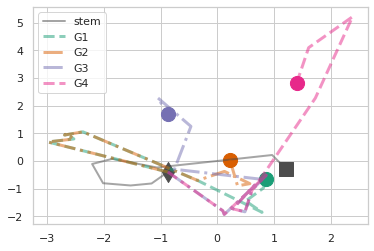

In [635]:
zz = (Xte/Xte.sum()).T@yy

stem_col = '0.3'
plt.scatter(zz.loc['H',0],zz.loc['H',1], marker='s', s=200, color=stem_col)
plt.scatter(zz.loc['D',0],zz.loc['D',1], marker='d', s=200, color=stem_col)
plt.plot(zz.loc['H':'D', 0], zz.loc['H':'D', 1], label='stem', alpha=0.5, lw=2, color=stem_col)


cols = plt.cm.Dark2([0,1,2,3])
ls = ['--','-.', '-.', '--']
for i, g in enumerate(tmz.goal_wells):
    zzz = zz.loc[tmz.all_zone_goal_seqs[g].values]
    plt.plot(zzz.loc['D':, 0], zzz.loc['D':, 1], ls=ls[i],label=g, alpha=0.5, lw=3, color=cols[i])
    plt.scatter(zz.loc[g,0],zz.loc[g,1], color=cols[i], s=200)

plt.legend()

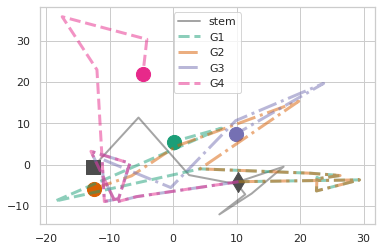

In [636]:
zz = (Xte/Xte.sum()).T@yy_lm

stem_col = '0.3'
plt.scatter(zz.loc['H',0],zz.loc['H',1], marker='s', s=200, color=stem_col)
plt.scatter(zz.loc['D',0],zz.loc['D',1], marker='d', s=200, color=stem_col)
plt.plot(zz.loc['H':'D', 0], zz.loc['H':'D', 1], label='stem', alpha=0.5, lw=2, color=stem_col)


cols = plt.cm.Dark2([0,1,2,3])
ls = ['--','-.', '-.', '--']
for i, g in enumerate(tmz.goal_wells):
    zzz = zz.loc[tmz.all_zone_goal_seqs[g].values]
    plt.plot(zzz.loc['D':, 0], zzz.loc['D':, 1], ls=ls[i],label=g, alpha=0.5, lw=3, color=cols[i])
    plt.scatter(zz.loc[g,0],zz.loc[g,1], color=cols[i], s=200)

plt.legend()


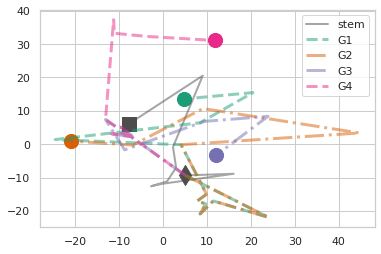

In [637]:
zz = (Xte/Xte.sum()).T@yy_o

stem_col = '0.3'
plt.scatter(zz.loc['H',0],zz.loc['H',1], marker='s', s=200, color=stem_col)
plt.scatter(zz.loc['D',0],zz.loc['D',1], marker='d', s=200, color=stem_col)
plt.plot(zz.loc['H':'D', 0], zz.loc['H':'D', 1], label='stem', alpha=0.5, lw=2, color=stem_col)


cols = plt.cm.Dark2([0,1,2,3])
ls = ['--','-.', '-.', '--']
for i, g in enumerate(tmz.goal_wells):
    zzz = zz.loc[tmz.all_zone_goal_seqs[g].values]
    plt.plot(zzz.loc['D':, 0], zzz.loc['D':, 1], ls=ls[i],label=g, alpha=0.5, lw=3, color=cols[i])
    plt.scatter(zz.loc[g,0],zz.loc[g,1], color=cols[i], s=200)

plt.legend()

In [675]:
ze.trial_ts_splits

{'train': {0: array([  1.,   1.,   1., ..., 128., 128., 128.]),
  1: array([  0.,   0.,   0., ..., 127., 127., 127.]),
  2: array([  0.,   0.,   0., ..., 127., 127., 127.]),
  3: array([  2.,   2.,   2., ..., 128., 128., 128.]),
  4: array([  0.,   0.,   0., ..., 128., 128., 128.])},
 'test': {0: array([  0.,   0.,   0., ..., 123., 123., 123.]),
  1: array([  2.,   2.,   2., ..., 128., 128., 128.]),
  2: array([  3.,   3.,   3., ..., 125., 125., 125.]),
  3: array([  1.,   1.,   1., ..., 127., 127., 127.]),
  4: array([  4.,   4.,   4., ..., 116., 116., 116.])}}

In [ ]:
Y_prob[Y_prob>max_p]=max_p
Y_prob[Y_prob<min_p]=min_p

Y_prob/Y_prob.sum(axis=1)

In [722]:
p = d['P(Z=z|z)']
-np.log(p/(1-p))

zones
H      2.338461
a_0    1.147812
a_1    2.901658
a_2    2.419783
a_3    2.809098
a_4    1.600029
a_5    2.262901
a_6    1.198445
D      1.835243
b_0    0.527189
b_1    1.085350
b_2    1.179614
b_3    0.813078
b_4    1.682350
b_5    0.285069
i1     2.954401
c_0    1.105024
c_1    1.393312
c_2    0.143892
G1     2.315228
d_0    0.426658
d_1    1.345692
d_2    2.743021
G2     2.416731
e_0    2.487483
e_1    1.766566
e_2    1.544716
e_3    2.040540
e_4    0.936445
e_5    2.818933
i2     1.712161
f_0    2.772532
f_1    3.126954
f_2    3.994330
G3     1.669657
g_0    3.452662
g_1    0.370662
g_2    1.067499
G4     0.634191
Name: P(Z=z|z), dtype: float64

In [715]:
Y = de.get_targets(0, 'train')
Yp = de.get_fold_decoder_pred_prob(0, 'train')

In [765]:
p = Yp.lookup(np.arange(len(Y)),  Y)

min_p = 1e-4
max_p = 1-min_p
p[p>max_p]=max_p
p[p<min_p]=min_p

/tmp/ipykernel_940/2705223735.py:1: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  p = Yp.lookup(np.arange(len(Y)),  Y)


In [766]:
lo_table = pd.DataFrame(index=range(len(Y)), data=np.array((Y, p/(1-p))).T, columns=['zones', 'lo'])

In [767]:
lo_table

,zones,lo
0,H,0.000221
1,H,0.000464
2,H,0.026661
3,H,75.603679
4,H,0.017157
...,...,...
56818,G1,0.0001
56819,G1,0.0001
56820,G1,0.0001
56821,G1,0.0001


In [108]:
trial_table = ta.trial_table
all_trials = np.arange(ta.n_trials)
e_trials = all_trials[::2]
o_trials = np.setdiff1d(all_trials,e_trials)

In [41]:
neural_data = ta.get_trial_neural_data()
spikes = ta.get_trial_neural_data(data_type='spikes')
zones = ta.get_trial_zones()
x,y = ta.get_trial_track_pos()

In [42]:
spikes

array([[array([0., 1., 0., ..., 0., 0., 0.], dtype=float32),
        array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
               0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
               0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
               0., 0., 0.,

In [142]:
def reformat_data(neural_data, zones, trials):
   

    Y = np.hstack(neural_data[:,trials].flatten()).reshape(n_units,-1)
    bad_samps = np.isnan(Y[0])
    Y = Y[:, ~bad_samps].T

    X = np.hstack(zones[trials].flatten())
    X = ta.tmz.get_pos_zone_mat(X[~bad_samps])
    
    return X, Y

def reformat_data_cue(neural_data, zones, trials):
    LC_trials = trials[trial_table.cue[trials]=='L']
    RC_trials = trials[trial_table.cue[trials]=='R']

    XL = np.hstack(zones[LC_trials].flatten())
    XR = np.hstack(zones[RC_trials].flatten())

    XLdf = ta.tmz.get_pos_zone_mat(XL)
    XLdf = XLdf.add_prefix('LC_')

    XRdf = ta.tmz.get_pos_zone_mat(XR)
    XRdf = XRdf.add_prefix('RC_')

    XC = pd.concat( (XLdf,XRdf )).reset_index(drop=True)
    XC = XC.fillna(0)
    
   
    YL = np.hstack(neural_data[:,LC_trials].flatten()).reshape(n_units,-1)
    YR = np.hstack(neural_data[:,RC_trials].flatten()).reshape(n_units,-1)

    YC = np.concatenate((YL,YR), axis=1).T
    YC[np.isnan(YC)] = 0 
    
    return XC, YC
    

In [146]:
Xtr, Ytr = reformat_data(neural_data, zones, e_trials)
Xte, Yte = reformat_data(neural_data, zones, o_trials)

In [89]:
def add_past(X, max_lag=5, alpha=1):
    X2 = X.copy()
    N = len(X)
    lags = np.arange(1,max_lag)
    beta = (1/lags)**(1/alpha)
    for l in lags:
        X2.loc[l:] = X2.loc[l:] + beta[l-1]*X.loc[0:(N-l-1)].values    
    X2 = X2.divide(X2.max(axis=1).values, axis=0)    
    return X2

def add_future(X, max_lag=5, alpha=1):
    X2 = X.copy()
    N = len(X)
    lags = np.arange(1,max_lag)
    beta = (1/lags)**(1/alpha)
    for l in lags:
        X2.loc[:(N-l-1)] = X2.loc[:(N-l-1)] + beta[l-1]*X.loc[l:].values    
    X2 = X2.divide(X2.max(axis=1).values, axis=0)
    return X2

# much faster and generalized version
def _add_zone_lags(X, max_lag=5, lags=None, decay_func=None):

    columns = X.columns
    X = X.values.copy().astype(float)
    X2 = X.copy()
    N = len(X)

    if lags is None:
        sgn = np.sign(max_lag)
        lags = np.arange(sgn, max_lag, sgn)
        
    if decay_func is None:
        beta = 1 / np.abs(lags)
    else:
        beta = decay_func(lags)

    for ii, l in enumerate(lags):
        if l == 0:
            X2 = beta[ii] * X
        elif l < 0:
            X2[abs(l):] += beta[ii] * X[:(N + l)]
        else:
            X2[:(N - l)] += beta[ii] * X[l:]

    X2 = pd.DataFrame(X2, columns=columns)
    X2 = X2.divide(np.abs(X2.max(axis=1)), axis=0)
    return X2


In [86]:
print (np.allclose(_add_zone_lags(Xtr,-5), add_past(Xtr)))
print(np.allclose(_add_zone_lags(Xtr,5), add_future(Xtr)))

True
True


In [93]:
max_lags = 50
Xtr2 = _add_zone_lags(Xtr,-max_lags)
Xte2 = _add_zone_lags(Xte, -max_lags)

Xtr3 = _add_zone_lags(Xtr,max_lags)
Xte3 = _add_zone_lags(Xte, max_lags)

In [95]:
model_past = lm.LinearRegression(fit_intercept=False).fit(Xtr2,Ytr)
model_past.score(Xte2, Yte)

0.06745117272748744

In [96]:
model_future = lm.LinearRegression(fit_intercept=False).fit(Xtr3,Ytr)
model_future.score(Xte3, Yte)

0.07796776450581591

In [152]:
model_present = lm.RidgeCV(fit_intercept=False, cv=10).fit(Xtr,Ytr)
#model_present = lm.LinearRegression(fit_intercept=False).fit(Xtr,Ytr)

model_present.score(Xtr, Ytr), model_present.score(Xte, Yte)

(0.07678040358719539, 0.0805898158348662)

In [97]:
y_hat3 = model_future.predict(Xte3)
rs.get_ar2(Yte.T, y_hat3.T, 39)

array([ 0.00879649,  0.40086179,  0.17710226,  0.09674862,  0.12933349,
        0.10823253,  0.1129871 ,  0.02018031,  0.04134713,  0.06115045,
       -0.0069926 ,  0.05088795,  0.04383592,  0.04851178,  0.04225324,
        0.00887449,  0.05639761,  0.09915892,  0.01784019,  0.02770897,
        0.0699419 ])

In [98]:
y_hat2 = model_future.predict(Xte2)
rs.get_ar2(Yte.T, y_hat2.T, 39)

array([-0.00684094,  0.23820876,  0.10935466,  0.0414307 ,  0.0623666 ,
        0.05235449,  0.08159259,  0.01642792,  0.02766973,  0.0354574 ,
       -0.07628971,  0.02862897,  0.02051831,  0.03256503,  0.01114706,
        0.02154545,  0.00981025,  0.09075473,  0.00633582,  0.00905353,
        0.00029301])

In [99]:
y_hat = model_present.predict(Xte)
rs.get_ar2(Yte.T, y_hat.T, 39)

array([0.03573362, 0.39378375, 0.17688925, 0.09359995, 0.13386661,
       0.08821641, 0.11197096, 0.02145762, 0.03844024, 0.0552901 ,
       0.01901432, 0.05969911, 0.03609965, 0.03765898, 0.03692215,
       0.01987943, 0.10973749, 0.10075554, 0.01510184, 0.02583267,
       0.0565309 ])

## try model separaed by cue

In [153]:
Xtr, Ytr = reformat_data_cue(neural_data, zones, e_trials)
Xte, Yte = reformat_data_cue(neural_data, zones, o_trials)

In [155]:
model_present = lm.RidgeCV(fit_intercept=False, cv=10).fit(Xtr,Ytr)
#model_present = lm.LinearRegression(fit_intercept=False).fit(Xtr,Ytr)
model_present.score(Xtr, Ytr), model_present.score(Xte, Yte), 

(0.09750692323730431, 0.07698708281081015)

## try with balanced cue trials in the training set

In [283]:
#def get_trial_balanced_cue_xval_sets(n_folds):

hermd

,0,1,2,3,4
0,train,train,train,test,train
1,test,train,train,train,train
2,train,test,train,train,train
3,train,train,train,test,train
4,test,train,train,train,train
...,...,...,...,...,...
150,NaN,NaN,NaN,NaN,NaN
151,train,train,test,train,train
152,NaN,NaN,NaN,NaN,NaN
153,train,train,NaN,train,test


In [293]:
trial_table[xval_table[2]=='test'].cue.value_counts()

L    16
R    15
Name: cue, dtype: int64

In [298]:
scores = pd.DataFrame(index=range(n_folds), columns=['train', 'test'])

model = lm.LinearRegression(fit_intercept=False)
for fold in range(n_folds):
    train_trials = all_trials[xval_table[fold]=='train']
    Xtr, Ytr = reformat_data(neural_data, zones, train_trials)
    
    test_trials = all_trials[xval_table[fold]=='test']
    Xte, Yte = reformat_data(neural_data, zones, test_trials)
    
    model_present = model.fit(Xtr,Ytr)
    
    #model_present = lm.RidgeCV(fit_intercept=False).fit(Xtr,Ytr)
    
    scores.loc[fold] = model_present.score(Xtr, Ytr), model_present.score(Xte, Yte)
scores

,train,test
0,0.092254,0.085975
1,0.089998,0.09397
2,0.09723,0.070376
3,0.090687,0.089968
4,0.090279,0.088414


In [301]:
model_present.predict(Xtr).shape

(51262, 21)

In [297]:
scores = pd.DataFrame(index=range(n_folds), columns=['train', 'test'])

for fold in range(n_folds):
    train_trials = all_trials[xval_table[fold]=='train']
    Xtr, Ytr = reformat_data_cue(neural_data, zones, train_trials)
    
    test_trials = all_trials[xval_table[fold]=='test']
    Xte, Yte = reformat_data_cue(neural_data, zones, test_trials)
    
    #model_present = lm.RidgeCV(fit_intercept=False).fit(Xtr,Ytr)
    model_present = lm.LinearRegression(fit_intercept=False).fit(Xtr,Ytr)
    
    scores.loc[fold] = model_present.score(Xtr, Ytr), model_present.score(Xte, Yte)
scores

,train,test
0,0.100547,0.082849
1,0.098464,0.092048
2,0.103374,0.077017
3,0.096371,0.094395
4,0.09879,0.085211


In [211]:
Xtr

,LC_H,LC_a_0,LC_a_1,LC_a_2,LC_a_3,LC_a_4,LC_a_5,LC_a_6,LC_D,LC_b_0,...,RC_e_5,RC_i2,RC_f_0,RC_f_1,RC_f_2,RC_G3,RC_g_0,RC_g_1,RC_g_2,RC_G4
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## test API

In [508]:
tmf = reload(tmf)
zone_encoder = tmf.ZoneEncoder(session_info)

In [494]:
zone_encoder.get_model_fits()

{0: LinearRegression(fit_intercept=False),
 1: LinearRegression(fit_intercept=False),
 2: LinearRegression(fit_intercept=False),
 3: LinearRegression(fit_intercept=False),
 4: LinearRegression(fit_intercept=False)}

In [495]:
%%time
d = zone_encoder.get_scores()

CPU times: user 9.75 s, sys: 150 ms, total: 9.9 s
Wall time: 990 ms


In [496]:
d2 = d.groupby(['unit', 'split', 'metric']).mean().reset_index()

<AxesSubplot:xlabel='split', ylabel='score'>

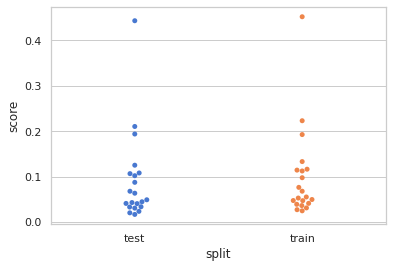

In [497]:
sns.swarmplot(data=d2[d2.metric=='r2'], y='score', x='split')

In [509]:
%%time
zone_encoder2 = tmf.ZoneEncoder(session_info, model_params=dict(add_sample_weights=True))
zone_encoder2.get_model_fits()

CPU times: user 26.9 s, sys: 460 ms, total: 27.4 s
Wall time: 3.87 s


{0: LinearRegression(fit_intercept=False),
 1: LinearRegression(fit_intercept=False),
 2: LinearRegression(fit_intercept=False),
 3: LinearRegression(fit_intercept=False),
 4: LinearRegression(fit_intercept=False)}

In [511]:
d = zone_encoder2.get_scores()
d3 = d.groupby(['unit', 'split', 'metric']).mean().reset_index()

<AxesSubplot:xlabel='split', ylabel='score'>

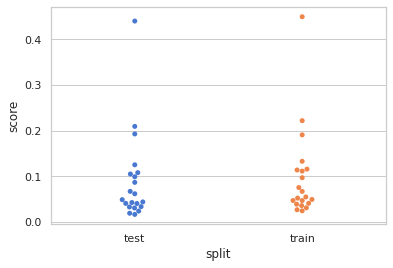

In [512]:
sns.swarmplot(data=d3[d3.metric=='r2'], y='score', x='split')

(array([ 1.,  0.,  1.,  0.,  2.,  2.,  4., 13., 20., 41.]),
 array([-0.02752736, -0.02444356, -0.02135976, -0.01827596, -0.01519216,
        -0.01210836, -0.00902456, -0.00594076, -0.00285696,  0.00022684,
         0.00331064]),
 <BarContainer object of 10 artists>)

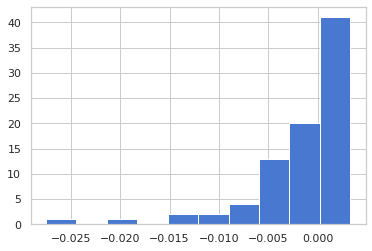

In [540]:
plt.hist(d2.score-d3.score)

In [679]:
%%time
tmf = reload(tmf)
zone_encoder3 = tmf.ZoneEncoder(session_info, model_params=dict(add_sample_weights=True), feature_params=dict(split_cue=True, max_lag=0))
zone_encoder3.get_model_fits()
d = zone_encoder3.get_scores()
d3 = d.groupby(['unit', 'split', 'metric']).mean().reset_index()

CPU times: user 45.2 s, sys: 1.19 s, total: 46.4 s
Wall time: 18.3 s


<AxesSubplot:xlabel='split', ylabel='score'>

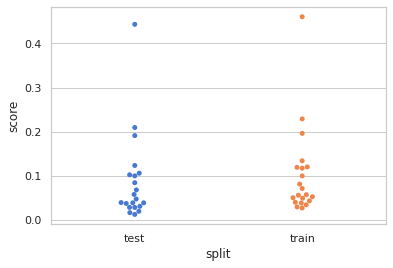

In [680]:
sns.swarmplot(data=d3, y='score', x='split')

In [664]:
%%time
tmf = reload(tmf)
zone_encoder4 = tmf.ZoneEncoder(session_info, model_params=dict(add_sample_weights=True), feature_params=dict(split_cue=True, max_lag=50))
zone_encoder4.get_model_fits()

CPU times: user 35.4 s, sys: 1.04 s, total: 36.4 s
Wall time: 10.6 s


{0: LinearRegression(fit_intercept=False),
 1: LinearRegression(fit_intercept=False),
 2: LinearRegression(fit_intercept=False),
 3: LinearRegression(fit_intercept=False),
 4: LinearRegression(fit_intercept=False)}

In [665]:
%%time
d = zone_encoder4.get_scores()
d6 = d.groupby(['unit', 'split', 'metric']).mean().reset_index()

CPU times: user 1.32 s, sys: 27.7 ms, total: 1.35 s
Wall time: 135 ms


<AxesSubplot:xlabel='split', ylabel='score'>

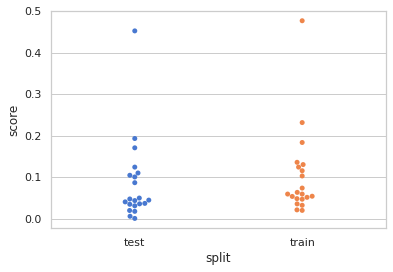

In [678]:
sns.swarmplot(data=d6[d6.metric=='r2'], y='score', x='split')

In [643]:
%%time
zone_encoder3.update_feature_params(**dict(max_lag=20))
zone_encoder3.get_model_fits()

CPU times: user 12.9 s, sys: 534 ms, total: 13.5 s
Wall time: 7.24 s


{0: LinearRegression(fit_intercept=False),
 1: LinearRegression(fit_intercept=False),
 2: LinearRegression(fit_intercept=False),
 3: LinearRegression(fit_intercept=False),
 4: LinearRegression(fit_intercept=False)}

<AxesSubplot:xlabel='split', ylabel='score'>

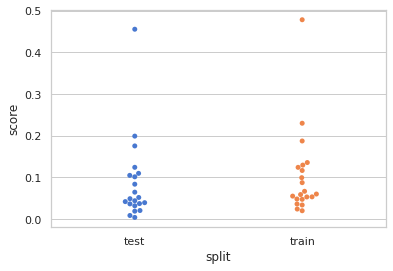

In [644]:
d = zone_encoder3.get_scores()
d5 = d.groupby(['unit', 'split', 'metric']).mean().reset_index()
sns.swarmplot(data=d5[d5.metric=='r2'], y='score', x='split')

In [645]:
fold=0
split='test'
y_hat = zone_encoder3.get_fold_prediction(fold_num=0, split=split)
y =  zone_encoder3.respones[split][fold]

In [637]:
y.shape, y_hat.shape

((18016, 21), (18016, 21))

In [646]:
sk_metrics.r2_score(y,y_hat, multioutput='raw_values')

array([0.03281148, 0.38293703, 0.05231696, 0.1062602 , 0.20409685,
       0.10456846, 0.10343162, 0.01089613, 0.03279292, 0.03084416,
       0.00463882, 0.0376646 , 0.04246379, 0.03788257, 0.03824775,
       0.01558782, 0.05880704, 0.0646105 , 0.00558782, 0.0310674 ,
       0.09574569])

In [647]:
sk_metrics.explained_variance_score(y,y_hat,multioutput='raw_values')

array([0.03420797, 0.38319098, 0.05465653, 0.10688423, 0.20545763,
       0.10479705, 0.10359568, 0.01116424, 0.03284505, 0.031282  ,
       0.00648055, 0.03795969, 0.04301455, 0.03809291, 0.03827704,
       0.01558801, 0.06005524, 0.07522877, 0.00558796, 0.03158891,
       0.09578495])

In [649]:
d[(d.metric=='r2') & (d.fold==fold+1) & (d.split==split)]

,unit,split,fold,metric,score
63,0,test,1,r2,0.047058
64,1,test,1,r2,0.481106
65,2,test,1,r2,0.291637
66,3,test,1,r2,0.139074
67,4,test,1,r2,0.114545
68,5,test,1,r2,0.113373
69,6,test,1,r2,0.108542
70,7,test,1,r2,0.020119
71,8,test,1,r2,0.035949
72,9,test,1,r2,0.048941


## decoder

In [63]:
%%time
tmf = reload(tmf)
tmz = tmf.TreeMazeZones()
zone_encoder = tmf.ZoneEncoder(session_info)

CPU times: user 19.5 s, sys: 306 ms, total: 19.8 s
Wall time: 3.61 s


In [64]:
zone_encoder.get_model_fits()
d = zone_encoder.get_scores()

<AxesSubplot:xlabel='split', ylabel='score'>

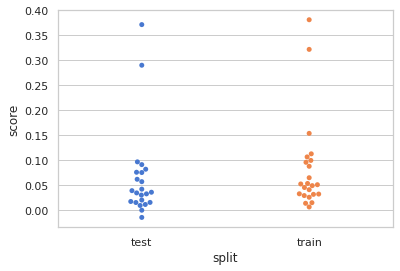

In [65]:
dd = d.groupby(['unit', 'split']).score.mean().reset_index()
sns.swarmplot(data=dd, x='split', y='score')

In [69]:
zone_encoder._get_zone_ts_splits()

In [70]:
split = 'train'
fold = 0
X = zone_encoder.response_splits[split][fold]
X2 = zone_encoder.get_fold_prediction(fold, split)
Y = zone_encoder.zone_ts_splits[split][fold]

In [262]:
X.shape, Y.shape, X2.shape

((47221, 20), (47221,), (47221, 20))

In [188]:
%%time
m = lm.LogisticRegression(class_weight='balanced', n_jobs=5, multi_class='multinomial', max_iter=100, tol=1e-3, solver='saga').fit(X,Y)
Y_hat = m.predict(X)
sk_metrics.balanced_accuracy_score(Y, Y_hat), sk_metrics.accuracy_score(Y, Y_hat) 

CPU times: user 15.6 s, sys: 44.3 ms, total: 15.6 s
Wall time: 13.8 s


(0.33860763689345164, 0.2826496313112648)

In [184]:
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB

In [193]:
%%time 
m_nb = ComplementNB(alpha=0.5, norm=True).fit(X,Y)
Y_hat2 = m_nb.predict(X)
sk_metrics.balanced_accuracy_score(Y,Y_hat2), sk_metrics.accuracy_score(Y, Y_hat2) 

CPU times: user 1.72 s, sys: 48.1 ms, total: 1.77 s
Wall time: 329 ms


(0.05769502379668453, 0.4608873167555391)

In [191]:
%%time 
m_nb = GaussianNB().fit(X,Y)
Y_hat2 = m_nb.predict(X)
sk_metrics.balanced_accuracy_score(Y,Y_hat2), sk_metrics.accuracy_score(Y, Y_hat2) 

CPU times: user 508 ms, sys: 0 ns, total: 508 ms
Wall time: 506 ms


(0.24457514500993646, 0.39946852506907415)

In [198]:
%%time 
m_nb = MultinomialNB(alpha=0.5).fit(X,Y)
Y_hat2 = m_nb.predict(X)
sk_metrics.balanced_accuracy_score(Y,Y_hat2), sk_metrics.accuracy_score(Y, Y_hat2) 

CPU times: user 1.8 s, sys: 52.2 ms, total: 1.85 s
Wall time: 331 ms


(0.30688223656522773, 0.3117575629586611)

In [72]:
Y_hat =m.predict(X)
Y_prob = m.predict_proba(X)
Y_prob_m = pd.DataFrame(data=Y_prob, columns=m.classes_)
Y_prob_m = Y_prob_m[zone_encoder.feature_names]

In [73]:
prob_corr_label = Y_prob_m.lookup(np.arange(len(Y)), Y)
p_table = pd.DataFrame( data=np.array((Y,prob_corr_label)).T, index=range(len(Y)), columns = ['zone', 'dist'] )
p_table = p_table.groupby('zone').mean()
p_table = p_table.T.reset_index(drop=True)[zone_encoder.feature_names]

/tmp/ipykernel_940/3174119954.py:1: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  prob_corr_label = Y_prob_m.lookup(np.arange(len(Y)), Y)


In [75]:
CM = pd.DataFrame(data=sk_metrics.confusion_matrix(Y,Y_hat, labels=zone_encoder.feature_names, normalize='true'), index=zone_encoder.feature_names, columns=zone_encoder.feature_names)
zone_scores = pd.DataFrame(index=zone_encoder.feature_names, data=np.diag(CM)).T
zone_scores

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,0.315552,0.261128,0.201299,0.293279,0.298,0.392336,0.232394,0.343203,0.192589,0.464481,...,0.432292,0.081384,0.469091,0.119565,0.246704,0.351998,0.7375,0.621053,0.330025,0.5822


In [76]:
zone_scores

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,0.315552,0.261128,0.201299,0.293279,0.298,0.392336,0.232394,0.343203,0.192589,0.464481,...,0.432292,0.081384,0.469091,0.119565,0.246704,0.351998,0.7375,0.621053,0.330025,0.5822


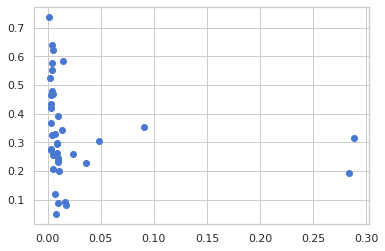

In [88]:
zone_frequency = pd.DataFrame(Y).value_counts()
zone_prob = zone_frequency/zone_frequency.sum()
plt.scatter(zone_prob[zone_encoder.feature_names].values, zone_scores.values.flatten())

In [90]:
sk_metrics.log_loss(Y,Y_prob)

2.6242565150218553e+00

In [91]:
sk_metrics.balanced_accuracy_score(Y, Y_hat)

0.3366043865890195

In [158]:
dist_mat = tmz.all_zone_dists
dists = dist_mat.lookup(Y,Y_hat)
prob_correct_zone = Y_prob_m.lookup(np.arange(len(Y)), Y)
prob_predicted_zone = Y_prob_m.lookup(np.arange(len(Y)), Y_hat)
log_p = -np.log(prob_correct_zone/(1-prob_correct_zone))
w_d = dists*prob_predicted_zone
dist_table = pd.DataFrame( data=np.array((Y, Y_hat, dists,prob_correct_zone, log_p, w_d )).T, index=range(len(Y)), columns = ['zones', 'zones_hat', 'dist', 'P(z)', 'lp', 'wd'] )
dist_m_table = dist_table.groupby('zones').mean().loc[zone_encoder.feature_names]
dist_m_table['acc'] = zone_scores.T
dist_m_table['freq'] = zone_frequency[zone_encoder.feature_names].values

/tmp/ipykernel_940/3269829282.py:2: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  dists = dist_mat.lookup(Y,Y_hat)
/tmp/ipykernel_940/3269829282.py:3: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  prob_correct_zone = Y_prob_m.lookup(np.arange(len(Y)), Y)
/tmp/ipykernel_940/3269829282.py:4: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  prob_predicted_zone = Y_prob_m.lookup(np.arange(len(Y)), Y_hat)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns 

In [167]:
dist_m_table.corr(method='kendall')

,dist,P(z),lp,wd,acc,freq
dist,1.000000,-0.506073,0.600540,0.832659,-0.476383,0.634706
P(z),-0.506073,1.000000,-0.846154,-0.403509,0.765182,-0.370020
lp,0.600540,-0.846154,1.000000,0.508772,-0.735493,0.475355
wd,0.832659,-0.403509,0.508772,1.000000,-0.427800,0.596894
acc,-0.476383,0.765182,-0.735493,-0.427800,1.000000,-0.340311
freq,0.634706,-0.370020,0.475355,0.596894,-0.340311,1.000000


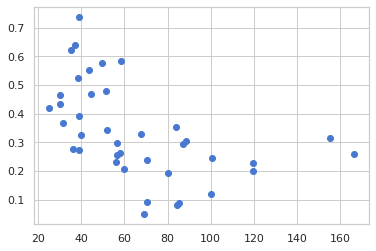

In [166]:
plt.scatter(dist_m_table.wd, dist_m_table.acc)

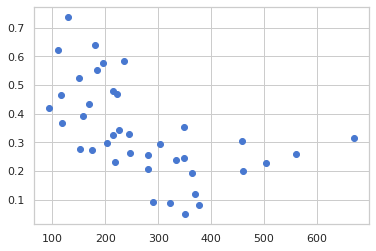

In [107]:
plt.scatter(dist_m_table.dist[zone_encoder.feature_names], zone_scores)

In [97]:
prob_correct_zone = Y_prob_m.lookup(np.arange(len(Y)), Y)
prob_incorrect_zone = Y_prob_m.lookup(np.arange(len(Y)), Y_hat)

/tmp/ipykernel_940/3301398303.py:1: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  prob_correct_zone = Y_prob_m.lookup(np.arange(len(Y)), Y)
/tmp/ipykernel_940/3301398303.py:2: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  prob_incorrect_zone = Y_prob_m.lookup(np.arange(len(Y)), Y_hat)


In [154]:
Y_prob_m

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,0.041150,0.060743,0.139418,0.120432,0.017298,0.006002,0.018035,0.048480,0.049577,0.000507,...,0.002148,0.040561,0.000810,0.012086,0.022658,0.016210,0.014275,0.014004,0.023908,0.003982
1,0.105036,0.074215,0.067831,0.095253,0.017597,0.003951,0.012973,0.031375,0.065058,0.000332,...,0.000541,0.027368,0.001215,0.024271,0.031404,0.058756,0.017064,0.033194,0.062518,0.010507
2,0.190175,0.084664,0.025281,0.042672,0.014913,0.005929,0.019435,0.028932,0.051621,0.000412,...,0.000622,0.029653,0.007183,0.037528,0.023455,0.076261,0.022099,0.023804,0.049243,0.012053
3,0.233447,0.080155,0.008324,0.015577,0.009679,0.005000,0.017046,0.018172,0.026623,0.000340,...,0.000804,0.030520,0.024875,0.034215,0.014579,0.051153,0.021247,0.014352,0.026379,0.015219
4,0.265663,0.077226,0.004839,0.009709,0.007179,0.001835,0.007059,0.007490,0.017236,0.000107,...,0.000392,0.023457,0.021538,0.029925,0.016112,0.044377,0.022315,0.021586,0.028271,0.043368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56818,0.009445,0.219046,0.045648,0.004073,0.000473,0.001026,0.014138,0.027549,0.005110,0.006233,...,0.002252,0.048119,0.001721,0.018460,0.011460,0.001839,0.000471,0.000299,0.001784,0.001534
56819,0.009305,0.116958,0.039594,0.016350,0.003422,0.005245,0.025156,0.051759,0.012456,0.017648,...,0.006270,0.056422,0.005551,0.022239,0.030242,0.006029,0.001282,0.000451,0.003646,0.003696
56820,0.015313,0.093470,0.031936,0.032768,0.008839,0.004588,0.015124,0.037761,0.014137,0.006722,...,0.002444,0.050572,0.001917,0.008910,0.026373,0.006731,0.002691,0.001259,0.005998,0.009243
56821,0.025093,0.124775,0.024293,0.018564,0.003354,0.000436,0.002855,0.012126,0.007000,0.000512,...,0.000279,0.030708,0.000201,0.002594,0.010543,0.003305,0.002702,0.003218,0.006834,0.013983


In [ ]:
B = 100


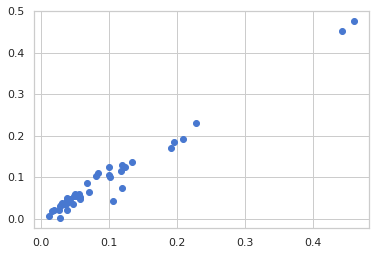

In [687]:

plt.scatter(d3.score, d6.score)

In [275]:
split ='test'
X_te = zone_encoder.respones[split][fold]
X2_te = zone_encoder.get_fold_prediction(fold, split)

trials = zone_encoder.get_fold_trials(fold, split)
valid_samps_locs = zone_encoder.valid_samps_locs[split][fold]
zones = np.hstack(zone_encoder.zones[trials].flatten())
zones = zones[valid_samps_locs]
Y_te = zones


In [273]:
Y_te_hat = m.predict(X_te)
Y_te_prob = m.predict_proba(X_te)
Y_te_prob_m = pd.DataFrame(data=Y_te_prob, columns=m.classes_)
Y_te_prob_m = Y_te_prob_m[zone_encoder.feature_names]

In [279]:
CM_te = pd.DataFrame(data=confusion_matrix(Y_te,Y_te_hat, labels=zone_encoder.feature_names, normalize='true'), index=zone_encoder.feature_names, columns=zone_encoder.feature_names)
zone_scores = pd.DataFrame(index=zone_encoder.feature_names, data=np.diag(CM_te)).T
zone_scores

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,0.60664,0.423729,0.142857,0.20915,0.099338,0.12766,0.090909,0.38764,0.220275,0.5,...,0.094118,0.068452,0.119048,0.019048,0.004484,0.296117,0.385714,0.163636,0.11165,0.28389


In [264]:
%%time
m_enc = lm.LogisticRegression(class_weight='balanced', n_jobs=5, multi_class='multinomial', max_iter=100, tol=1e-3, solver='saga').fit(X2,Y)

In [265]:
Y_hat2 =m_enc.predict(X2)
Y_prob2 = m_enc.predict_proba(X2)
Y_prob2_m = pd.DataFrame(data=Y_prob2, columns=m.classes_)
Y_prob2_m = Y_prob2_m[zone_encoder.feature_names]

In [268]:
prob_corr_label2 = Y_prob2_m.lookup(np.arange(len(Y)), Y)
p_table2 = pd.DataFrame( data=np.array((Y,prob_corr_label2)).T, index=range(len(Y)), columns = ['zone', 'dist'] )
p_table2 = p_table2.groupby('zone').mean()
p_table2 = p_table2.T.reset_index(drop=True)[zone_encoder.feature_names]

/tmp/ipykernel_11608/788208363.py:1: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  prob_corr_label2 = Y_prob2_m.lookup(np.arange(len(Y)), Y)


In [269]:
CM2 = pd.DataFrame(data=confusion_matrix(Y,Y_hat2, labels=zone_encoder.feature_names, normalize='true'), index=zone_encoder.feature_names, columns=zone_encoder.feature_names)
zone_scores2 = pd.DataFrame(index=zone_encoder.feature_names, data=np.diag(CM2)).T
zone_scores2

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [283]:
Y_te_hat2 = m_enc.predict(X2_te)
Y_te_prob2 = m_enc.predict_proba(X2_te)
Y_te_prob2_m = pd.DataFrame(data=Y_te_prob2, columns=m.classes_)
Y_te_prob2_m = Y_te_prob2_m[zone_encoder.feature_names]

In [284]:
CM_te2 = pd.DataFrame(data=confusion_matrix(Y_te,Y_te_hat2, labels=zone_encoder.feature_names, normalize='true'), index=zone_encoder.feature_names, columns=zone_encoder.feature_names)
zone_scores_te2 = pd.DataFrame(index=zone_encoder.feature_names, data=np.diag(CM_te2)).T
zone_scores_te2

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<AxesSubplot:>

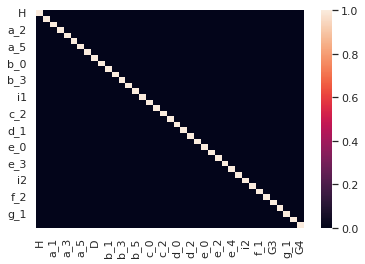

In [292]:
)

In [60]:
dist_mat = tmz.all_zone_dists
dists = dist_mat.lookup(Y,Y_hat)

NameError: name 'tmz' is not defined

In [219]:
d_table = pd.DataFrame( data=np.array((Y,dists)).T, index=range(len(Y)), columns = ['zone', 'dist'] )
d_table2 = d_table.groupby('zone').mean()
d_table2 = d_table2.T
#d_table2 = d_table[zone_encoder.feature_names]
d_table2.reset_index(drop=True)[zone_encoder.feature_names]

zone,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,306.12696,343.868595,367.461138,328.752601,296.018348,361.775981,322.469918,239.025141,324.171532,231.246358,...,288.076963,379.799402,428.865122,382.1004,460.835553,398.873369,208.099116,320.35016,492.080345,514.024182


In [170]:
dist_mat2 = dist_mat.copy()
dist_mat2 = dist_mat2/dist_mat2.max(axis=1)
dist_mat2

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
H,0.000000,0.087716,0.142389,0.202714,0.269589,0.344108,0.427610,0.521754,0.698677,0.824287,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.964909,0.972174,0.949252,0.895402
a_0,0.080753,0.000000,0.050343,0.105899,0.167499,0.236152,0.313098,0.399872,0.563005,0.692982,...,0.890265,0.903656,0.902806,0.909271,0.912755,0.920624,0.870305,0.884089,0.867489,0.828755
a_1,0.124920,0.047975,0.000000,0.052948,0.111662,0.177107,0.250467,0.333210,0.488801,0.621425,...,0.830782,0.851508,0.849932,0.859906,0.865233,0.877317,0.819451,0.836825,0.823778,0.793508
a_2,0.169084,0.095947,0.050340,0.000000,0.055828,0.118065,0.187841,0.266552,0.414602,0.550147,...,0.771793,0.799848,0.797313,0.810768,0.817882,0.834103,0.769390,0.790358,0.780935,0.759269
a_3,0.213244,0.143914,0.100675,0.052943,0.000000,0.059029,0.125219,0.199900,0.340409,0.479271,...,0.713419,0.748775,0.745005,0.761903,0.770735,0.790998,0.720285,0.744838,0.739112,0.726179
a_4,0.257400,0.191877,0.151005,0.105881,0.055822,0.000000,0.062605,0.133256,0.266225,0.409006,...,0.655826,0.698419,0.693078,0.713366,0.723831,0.748020,0.672347,0.700448,0.698492,0.694403
a_5,0.301548,0.239832,0.201328,0.158810,0.111636,0.059021,0.000000,0.066622,0.192051,0.339726,...,0.599239,0.648947,0.641623,0.665230,0.677222,0.705195,0.625843,0.657418,0.659297,0.664129
a_6,0.345689,0.287778,0.251640,0.211730,0.167439,0.118030,0.062593,0.000000,0.117892,0.272182,...,0.543970,0.600577,0.590767,0.617589,0.630973,0.662551,0.581118,0.616033,0.621798,0.635572
D,0.415859,0.363998,0.331623,0.295856,0.256151,0.211838,0.162098,0.105909,0.000000,0.173359,...,0.459958,0.526671,0.511559,0.543167,0.558389,0.595209,0.514791,0.554509,0.566478,0.594299
b_0,0.501444,0.457914,0.430900,0.401239,0.368596,0.332629,0.293065,0.249910,0.177182,0.000000,...,0.446117,0.510559,0.474005,0.504312,0.514440,0.545079,0.521680,0.561088,0.578320,0.616677


In [171]:
p_dists = (Y_prob_m*(1-dist_mat2).loc[Y].reset_index(drop=True)).sum(axis=1)
d_table = pd.DataFrame( data=np.array((Y,p_dists)).T, index=range(len(Y)), columns = ['zone', 'dist'] )
dp_table2 = d_table.groupby('zone').mean()
#dp_table2


zone,D,G1,G2,G3,G4,H,a_0,a_1,a_2,a_3,...,e_4,e_5,f_0,f_1,f_2,g_0,g_1,g_2,i1,i2
dist,324.171532,318.336697,600.625961,398.873369,514.024182,306.12696,343.868595,367.461138,328.752601,296.018348,...,322.813106,288.076963,428.865122,382.1004,460.835553,208.099116,320.35016,492.080345,380.012073,379.799402


In [162]:
#Y_prob*(1-dist_mat2.loc[Y])
Y_prob*(dist_mat2).loc[Y].reset_index(drop=True)

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,0.000000,0.002669,0.005433,0.008934,0.002985,0.000411,0.000103,0.000058,0.000643,0.000006,...,0.000074,0.000320,0.000645,0.000039,0.000306,0.000025,0.001316,0.002992,0.000702,0.000168
1,0.000000,0.014594,0.025955,0.047702,0.014891,0.002027,0.000290,0.000066,0.000585,0.000018,...,0.000793,0.001296,0.001907,0.000061,0.000403,0.000031,0.003684,0.003437,0.001833,0.000258
2,0.000000,0.022916,0.026747,0.050399,0.028768,0.005572,0.000758,0.000110,0.000656,0.000106,...,0.006489,0.006540,0.004818,0.000297,0.001153,0.000112,0.006197,0.003631,0.004686,0.000493
3,0.000000,0.019243,0.016059,0.023818,0.022952,0.009324,0.001911,0.000265,0.001537,0.001745,...,0.034570,0.028749,0.014530,0.002967,0.007374,0.001229,0.015338,0.009406,0.017363,0.003087
4,0.000000,0.010834,0.008780,0.008334,0.008154,0.005756,0.002179,0.000281,0.002643,0.016575,...,0.050354,0.035992,0.015457,0.007353,0.020547,0.004713,0.023327,0.018053,0.031649,0.014291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47216,0.006227,0.019514,0.031028,0.052965,0.036160,0.064384,0.069012,0.038051,0.014362,0.003656,...,0.042823,0.011696,0.005550,0.003774,0.002321,0.000000,0.003785,0.002329,0.010631,0.032459
47217,0.009688,0.011268,0.016911,0.023426,0.011315,0.037328,0.064283,0.060285,0.021693,0.002407,...,0.022320,0.015348,0.008278,0.005524,0.002724,0.000000,0.003583,0.001773,0.010474,0.040459
47218,0.012940,0.005817,0.009099,0.010907,0.004701,0.024401,0.066228,0.093903,0.028198,0.001327,...,0.012558,0.014058,0.009007,0.005420,0.002568,0.000000,0.002076,0.000930,0.006873,0.041187
47219,0.010820,0.004724,0.008087,0.011713,0.007031,0.040643,0.128160,0.192344,0.028228,0.000957,...,0.019237,0.011859,0.005484,0.002880,0.001737,0.000000,0.001072,0.000509,0.003591,0.032487


In [166]:
from sklearn.metrics import confusion_matrix, log_loss

<AxesSubplot:>

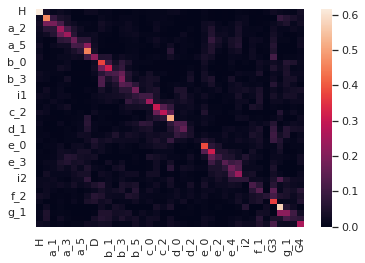

In [188]:
CM = pd.DataFrame(data=confusion_matrix(Y,Y_hat, labels=zone_encoder.feature_names, normalize='true'),index=zone_encoder.feature_names, columns=zone_encoder.feature_names)
sns.heatmap(CM)

In [243]:
CM.corrwith(dist_mat, axis=1)

H     -0.405050
a_0   -0.405925
a_1   -0.599987
a_2   -0.607003
a_3   -0.574817
a_4   -0.548154
a_5   -0.490816
a_6   -0.375090
D     -0.398056
b_0   -0.419587
b_1   -0.487880
b_2   -0.555467
b_3   -0.506706
b_4   -0.543920
b_5   -0.482873
i1    -0.526073
c_0   -0.523678
c_1   -0.508676
c_2   -0.475678
G1    -0.443125
d_0   -0.504108
d_1   -0.399601
d_2   -0.454209
G2    -0.263923
e_0   -0.424814
e_1   -0.554253
e_2   -0.475621
e_3   -0.491429
e_4   -0.398799
e_5   -0.439945
i2    -0.503602
f_0   -0.299449
f_1   -0.458047
f_2   -0.457419
G3    -0.395156
g_0   -0.328162
g_1   -0.459804
g_2   -0.435814
G4    -0.463950
dtype: float64

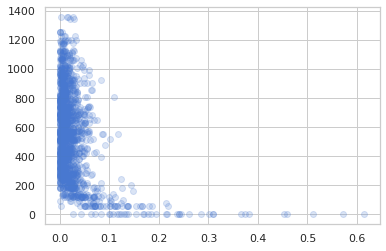

In [247]:
plt.scatter(CM.to_numpy().flatten(), dist_mat.to_numpy().flatten(), alpha=0.2)

In [253]:
prob_corr_label = Y_prob_m.lookup(np.arange(len(Y)), Y)
p_table = pd.DataFrame( data=np.array((Y,prob_corr_label)).T, index=range(len(Y)), columns = ['zone', 'dist'] )
p_table = p_table.groupby('zone').mean()
p_table = p_table.T.reset_index(drop=True)[zone_encoder.feature_names]

/tmp/ipykernel_11608/3174119954.py:1: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  prob_corr_label = Y_prob_m.lookup(np.arange(len(Y)), Y)


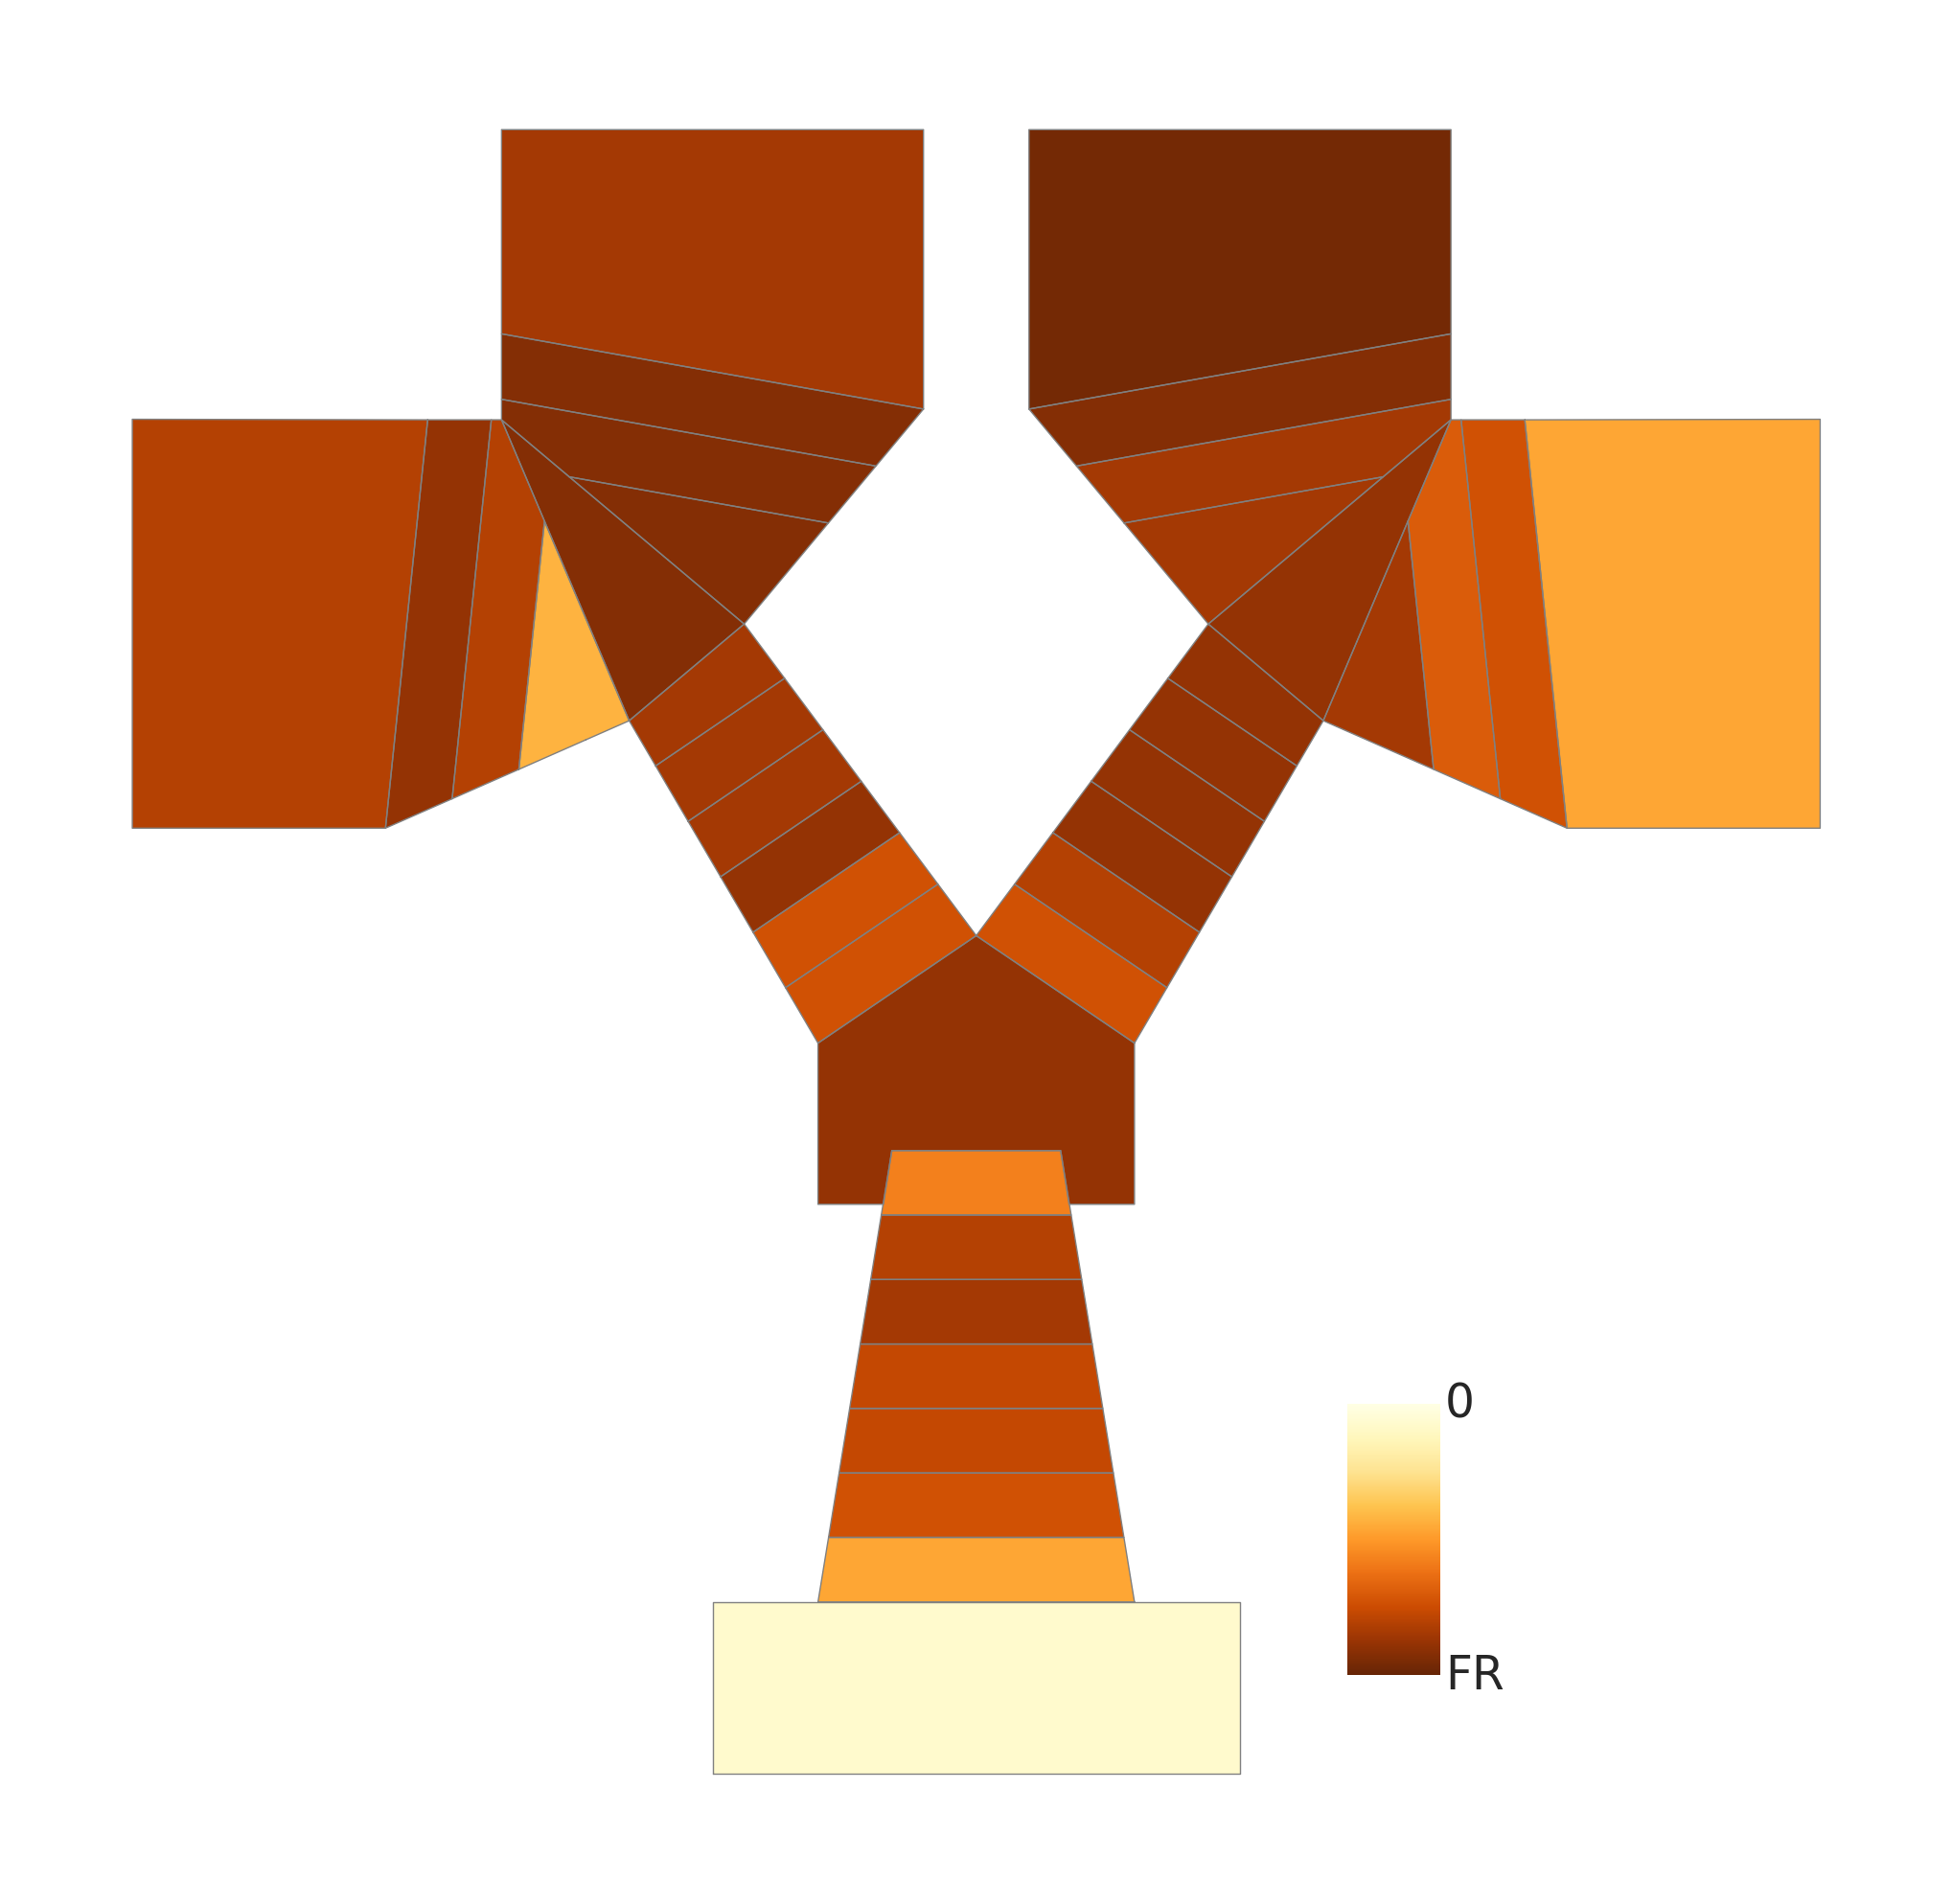

In [255]:
tmz.plot_zone_activity(p_table)

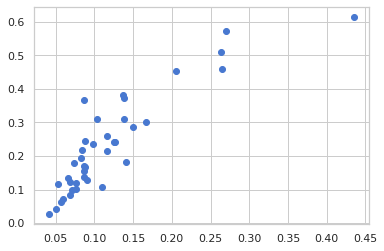

In [256]:
plt.scatter(p_table,zone_scores)

In [220]:
CM = pd.DataFrame(data=confusion_matrix(Y,Y_hat, labels=zone_encoder.feature_names, normalize='true'), index=zone_encoder.feature_names, columns=zone_encoder.feature_names)

zone_scores = pd.DataFrame(index=zone_encoder.feature_names, data=np.diag(CM)).T
zone_scores

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,0.614676,0.458967,0.183303,0.240964,0.241379,0.170297,0.10728,0.451718,0.217015,0.373134,...,0.236025,0.070997,0.115942,0.133333,0.062593,0.366046,0.57265,0.214477,0.083151,0.260761


/tmp/ipykernel_11608/2100419782.py:2: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  plt.scatter((Y_prob_m.lookup(np.arange(len(Y_hat)), Y)), dists, alpha=0.05, linewidth=0)


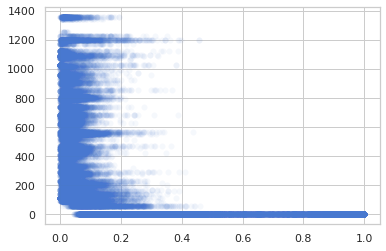

In [236]:
# plt.scatter((Y_prob_m.lookup(np.arange(len(Y_hat)), Y)), (Y_prob_m.lookup(np.arange(len(Y_hat)), Y_hat)), alpha=0.05, linewidth=0)
plt.scatter((Y_prob_m.lookup(np.arange(len(Y_hat)), Y)), dists, alpha=0.05, linewidth=0)

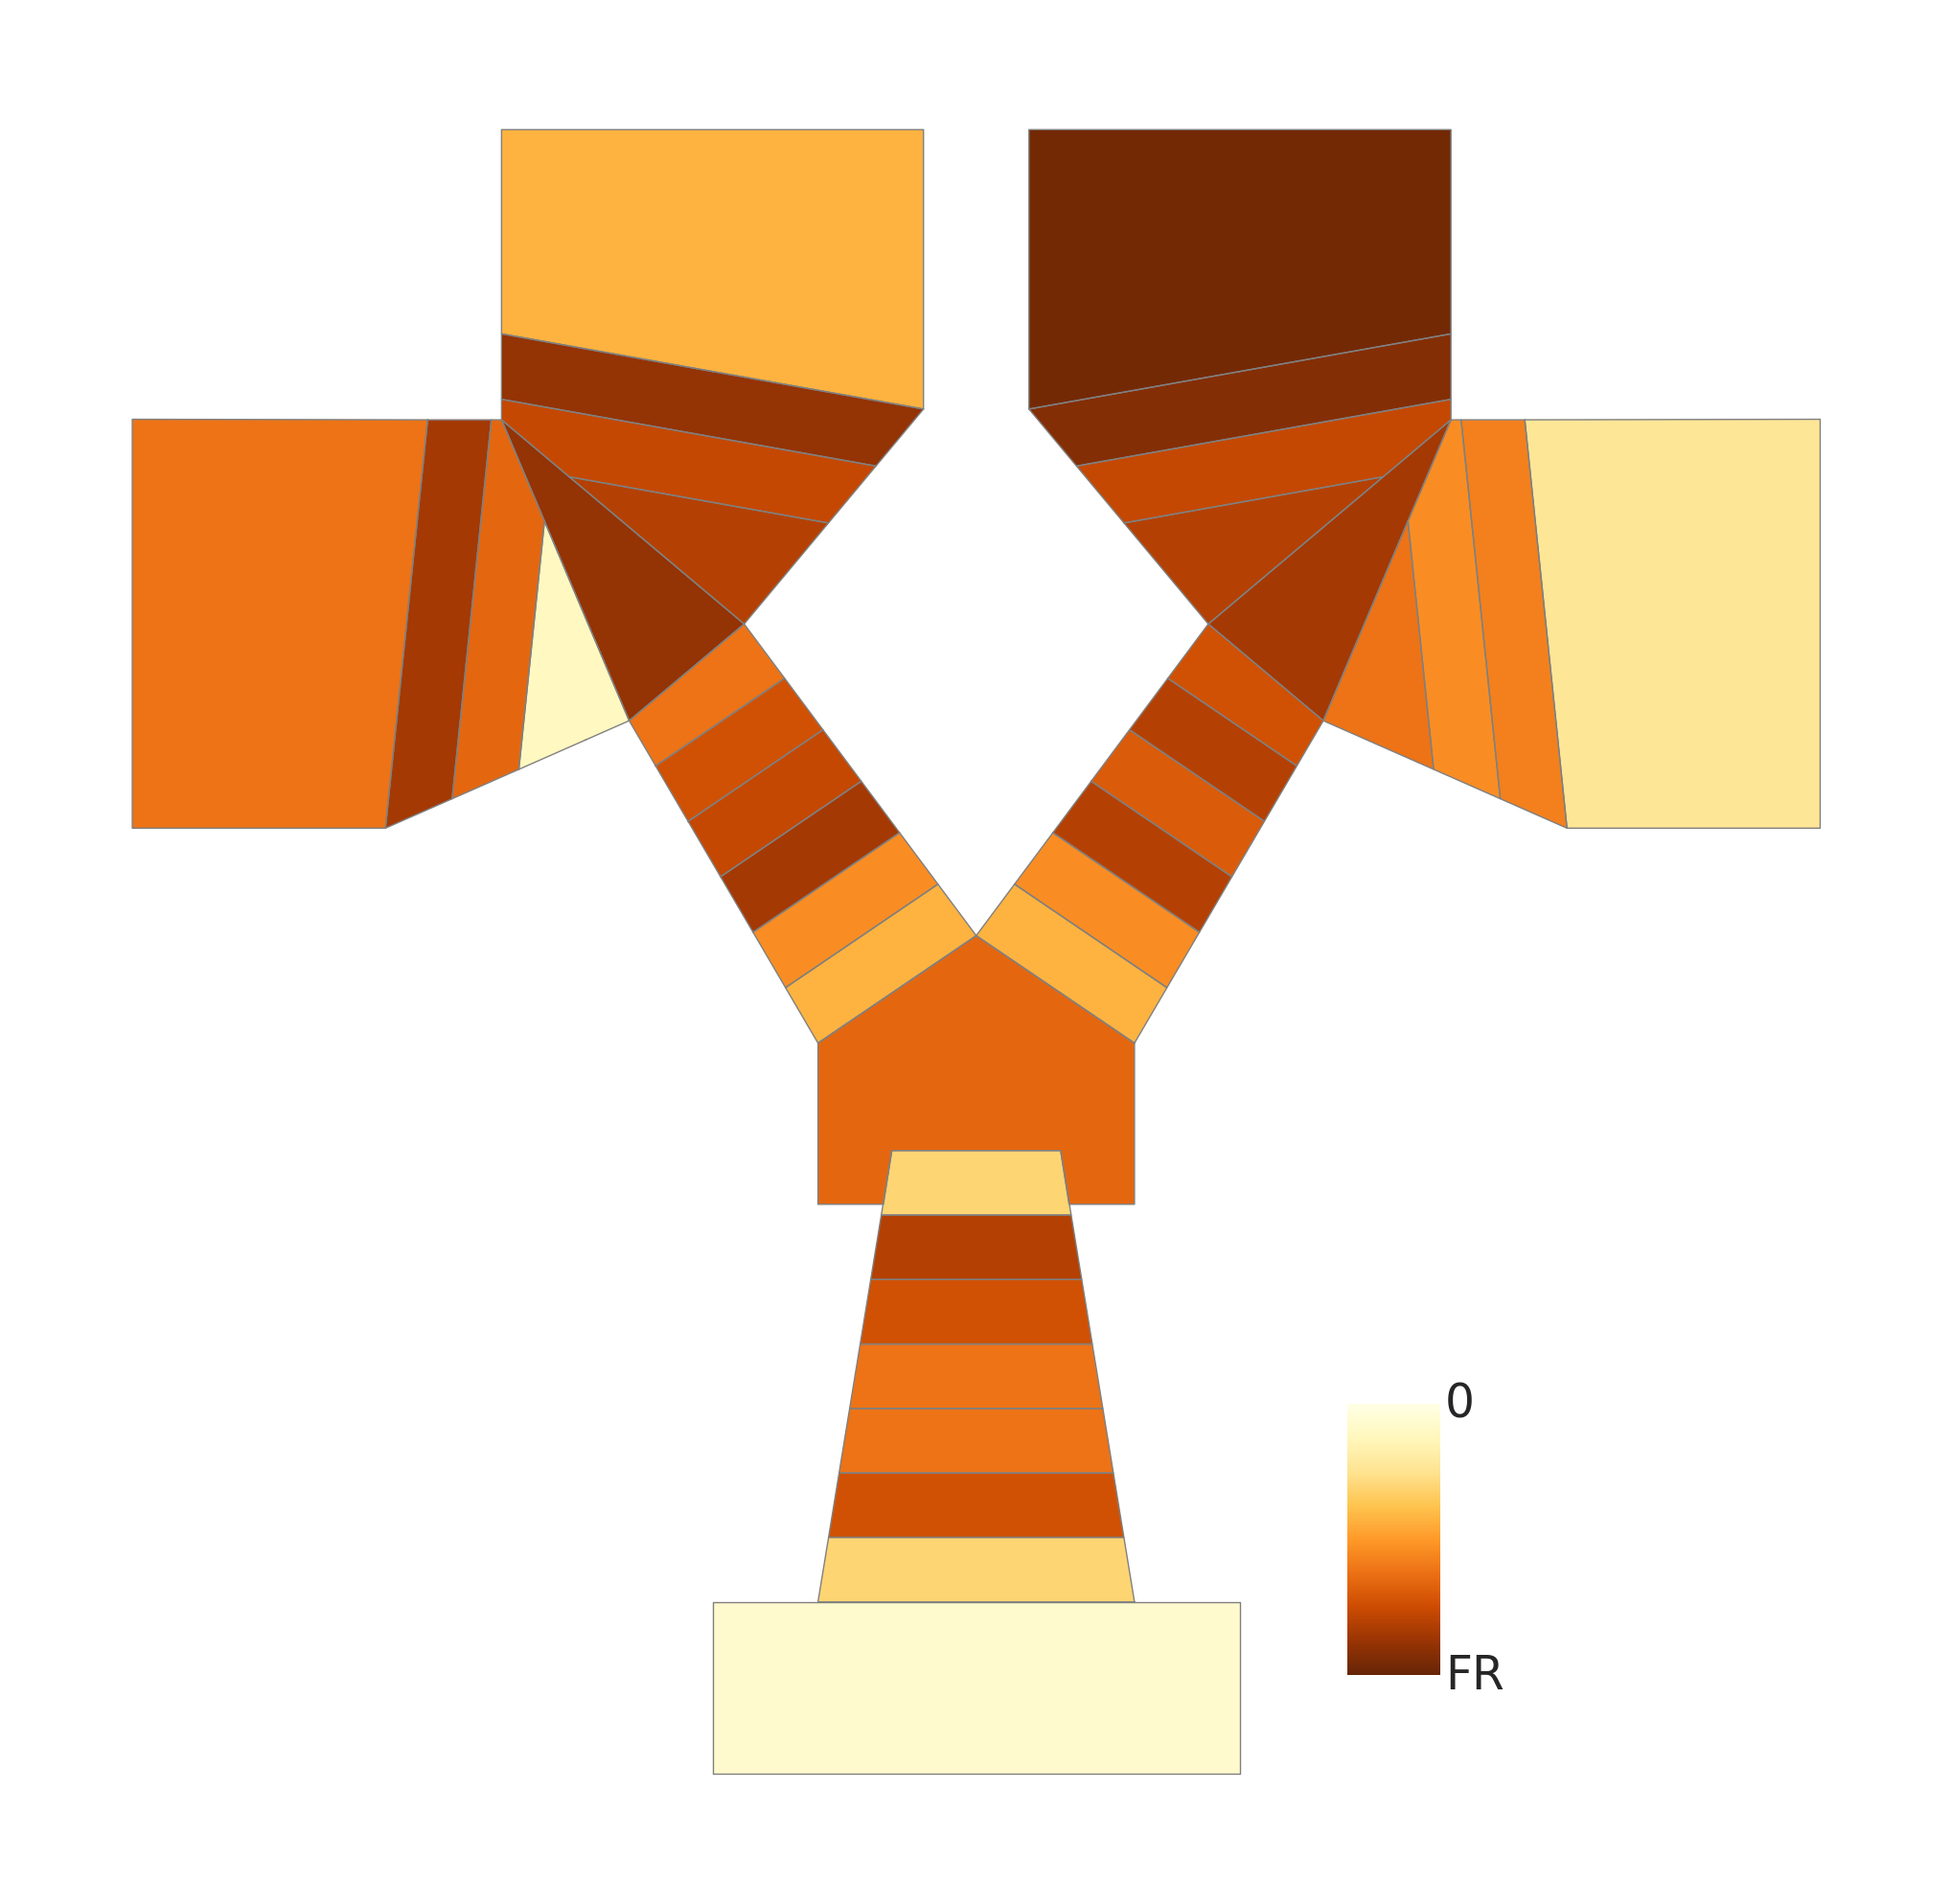

In [210]:
#CM.to_numpy()
tmz.plot_zone_activity(pd.DataFrame(index=zone_encoder.feature_names, data=np.diag(CM)).T)

In [103]:
#Y_prob['H']*dist_mat.loc[Y]
dist_mat.loc[Y].reset_index(drop=True)

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,0.000000,109.655172,169.629630,229.600000,289.565217,349.523810,409.473684,469.411765,564.696382,680.913119,...,958.384758,1076.150599,1095.548860,1171.909854,1225.214629,1357.903575,1024.228161,1090.062573,1119.424547,1199.425875
1,0.000000,109.655172,169.629630,229.600000,289.565217,349.523810,409.473684,469.411765,564.696382,680.913119,...,958.384758,1076.150599,1095.548860,1171.909854,1225.214629,1357.903575,1024.228161,1090.062573,1119.424547,1199.425875
2,0.000000,109.655172,169.629630,229.600000,289.565217,349.523810,409.473684,469.411765,564.696382,680.913119,...,958.384758,1076.150599,1095.548860,1171.909854,1225.214629,1357.903575,1024.228161,1090.062573,1119.424547,1199.425875
3,0.000000,109.655172,169.629630,229.600000,289.565217,349.523810,409.473684,469.411765,564.696382,680.913119,...,958.384758,1076.150599,1095.548860,1171.909854,1225.214629,1357.903575,1024.228161,1090.062573,1119.424547,1199.425875
4,0.000000,109.655172,169.629630,229.600000,289.565217,349.523810,409.473684,469.411765,564.696382,680.913119,...,958.384758,1076.150599,1095.548860,1171.909854,1225.214629,1357.903575,1024.228161,1090.062573,1119.424547,1199.425875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47216,1357.903575,1250.119111,1191.312267,1132.631873,1074.099010,1015.739702,957.586461,899.680470,808.236425,740.165352,...,413.355316,326.878249,269.780911,199.829404,141.143678,0.000000,417.994626,404.369284,433.956501,549.275858
47217,1357.903575,1250.119111,1191.312267,1132.631873,1074.099010,1015.739702,957.586461,899.680470,808.236425,740.165352,...,413.355316,326.878249,269.780911,199.829404,141.143678,0.000000,417.994626,404.369284,433.956501,549.275858
47218,1357.903575,1250.119111,1191.312267,1132.631873,1074.099010,1015.739702,957.586461,899.680470,808.236425,740.165352,...,413.355316,326.878249,269.780911,199.829404,141.143678,0.000000,417.994626,404.369284,433.956501,549.275858
47219,1357.903575,1250.119111,1191.312267,1132.631873,1074.099010,1015.739702,957.586461,899.680470,808.236425,740.165352,...,413.355316,326.878249,269.780911,199.829404,141.143678,0.000000,417.994626,404.369284,433.956501,549.275858


In [76]:
Y_prob.loc[s]*dist_mat.loc[Y[s]]


D       2.135992
G1      0.524260
G2     13.863242
G3      6.399383
G4     19.143929
H       0.000000
a_0    13.544360
a_1    10.460039
a_2     9.439263
a_3     8.758323
a_4     5.846304
a_5     2.086755
a_6     0.252626
b_0    13.692121
b_1    31.889270
b_2    25.618055
b_3    45.782089
b_4    23.522701
b_5    34.385008
c_0     9.763267
c_1     4.862413
c_2     3.404212
d_0    16.314736
d_1    28.037114
d_2    22.685638
e_0     6.335978
e_1     7.054864
e_2    18.202215
e_3    31.710479
e_4    38.310089
e_5    48.258431
f_0    16.933455
f_1     8.616584
f_2    25.174986
g_0    24.761420
g_1    20.242547
g_2    37.322565
i1     70.396742
i2     38.732973
dtype: float64

In [61]:
Y[s], Y_hat[s], pd.DataFrame(index=m.classes_, data=Y_prob[s])

('H',
 'H',
             0
 D    0.000921
 G1   0.000001
 G2   0.000012
 G3   0.000025
 G4   0.000188
 H    0.855278
 a_0  0.030430
 a_1  0.038156
 a_2  0.044074
 a_3  0.011072
 a_4  0.001195
 a_5  0.000241
 a_6  0.000110
 b_0  0.000007
 b_1  0.000345
 b_2  0.000697
 b_3  0.001222
 b_4  0.000188
 b_5  0.000355
 c_0  0.000100
 c_1  0.000050
 c_2  0.000310
 d_0  0.000064
 d_1  0.000013
 d_2  0.000004
 e_0  0.006231
 e_1  0.000780
 e_2  0.000557
 e_3  0.000365
 e_4  0.000027
 e_5  0.000074
 f_0  0.000645
 f_1  0.000039
 f_2  0.000306
 g_0  0.001364
 g_1  0.003078
 g_2  0.000740
 i1   0.000417
 i2   0.000320)

In [332]:
fold = 0
split = 'train'
trials = zone_encoder.get_fold_trials(fold, split)

In [333]:

zones = zone_encoder.zones

trial_vec = np.empty(0)
for tr in trials:
    trial_vec = np.append(trial_vec, tr*np.ones(len(zones[tr])))
trial_vec

array([  1.,   1.,   1., ..., 143., 143., 143.])

In [334]:
len(trial_vec)

47369

In [338]:
trial_vec[zone_encoder.valid_samps_locs[split][fold]]

array([  1.,   1.,   1., ..., 143., 143., 143.])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [58]:
m.feature_names_in_

AttributeError: 'LogisticRegression' object has no attribute 'feature_names_in_'

## tmz zone distances

In [631]:
tmf = reload(tmf)
tmz = tmf.TreeMazeZones()

<AxesSubplot:>

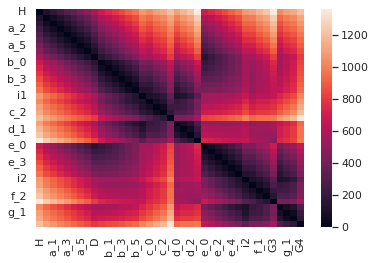

In [633]:
#tmz.all_zone_dists.iloc[0]
sns.heatmap(tmz.all_zone_dists)

In [617]:
z1 = tmz.all_zone_centroids.loc['a_0']
z2 = tmz.all_zone_centroids.loc['a_1']

In [624]:
d =  np.sqrt( (z1.x-z2.x)**2 + (z1.y-z2.y)**2)
d

59.97445721583651

In [401]:
tmf = reload(tmf)
zone_encoder = tmf.ZoneEncoder(session_info)

In [374]:
model_fits = zone_encoder.get_model_fits(model_type='ridge')
scores = zone_encoder.get_scores(model_fits)

In [375]:
a=scores.groupby(['unit', 'split'])['score'].mean()

In [376]:
feature_type='zones_cue'
model_fits = zone_encoder.get_model_fits(feature_type=feature_type, model_type='ridge')
scores_cue = zone_encoder.get_scores(model_fits, feature_type=feature_type)

In [377]:
b= scores_cue.groupby(['unit', 'split'])['score'].mean()

<AxesSubplot:xlabel='split', ylabel='score'>

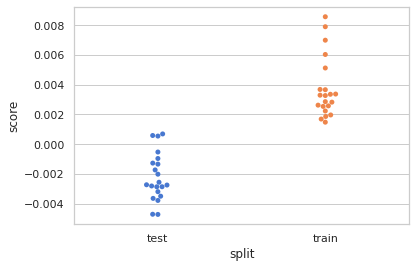

In [378]:
sns.swarmplot(y='score',x='split', data=(b-a).reset_index())

In [380]:
zone_encoder.trial_table

,t0,tD,tE,tE_1,tE_2,dur,cue,dec,correct,long,goal,grw,sw,vsw
0,1634,2321,2955,2606,2955,1321,L,L,1.0,1.0,4.0,1,0,0
1,3119,3201,3416,3416,3587,296,R,L,0.0,NaN,NaN,0,1,1
2,3929,4272,4627,4546,4627,698,R,R,1.0,1.0,2.0,1,0,0
3,4865,5172,5401,5401,5527,536,R,L,0.0,NaN,NaN,0,0,0
4,5969,6191,7198,7198,7198,1229,R,L,0.0,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,123346,123522,126105,126105,126717,2758,L,R,0.0,NaN,NaN,0,1,1
151,126876,127196,127761,127761,128028,885,R,L,0.0,NaN,NaN,0,1,0
152,128520,128790,134633,134633,136150,6113,L,R,0.0,NaN,NaN,0,1,0
153,137025,137442,137864,137644,137864,838,L,L,1.0,1.0,4.0,1,0,0


In [402]:
trial_table = zone_encoder.trial_table
all_trials = zone_encoder.all_trials
xval_table = zone_encoder.xval_trial_table

co_trials = all_trials[trial_table.correct==1]
inco_trials = all_trials[trial_table.correct==0]

fold = 0
split = 'train'

train_trials = all_trials[zone_encoder.xval_trial_table[fold]==split]
n_train_trials = len(train_trials)

co_train_trials = np.intersect1d(train_trials, co_trials)
inco_train_trials = np.intersect1d(train_trials, inco_trials)

n_co_train_trials = len(co_train_trials)
n_inco_train_trials = len(inco_train_trials)


co_weight = n_inco_train_trials/n_train_trials
inco_weight = n_co_train_trials/n_train_trials


In [403]:
n_co_train, n_inco_train, co_weight, inco_weight


(84, 31, 0.2672413793103448, 0.7241379310344828)

In [407]:
x,y = zone_encoder.reformat_data_cue(train_trials)

In [408]:
x.shape

(55107, 78)

In [418]:
all_train_samps = zone_encoder.ta.get_trial_concat_samps(train_trials)
all_train_samps.shape

(55492,)

In [417]:
np.intersect1d(all_train_samps, zone_encoder.ta.all_blank_samps).shape

(385,)

array([False, False, False, ..., False, False, False])

In [420]:
all_train_samps.shape[0] - x.shape[0]

385

In [436]:
train_samp_weights = np.empty(0)
for tr in train_trials:
    n_trial_samps = len(zone_encoder.zones[tr])
    
    if trial_table.correct[tr] == 1:
        trial_samp_weight = co_weight
    else:
        trial_samp_weight = inco_weight
    
    train_samp_weights = np.concatenate((train_samp_weights, trial_samp_weight*np.ones(n_trial_samps)))

In [437]:
train_samp_weights

array([0.72413793, 0.72413793, 0.72413793, ..., 0.26724138, 0.26724138,
       0.26724138])

In [461]:
tt = pd.DataFrame()
t0 = zone_encoder.ta.tmz.get_pos_zone_mat(zone_encoder.zones[0])
t0 = t0.add_prefix("LC_")
t2 = zone_encoder.ta.tmz.get_pos_zone_mat(zone_encoder.zones[2])
t2 = t2.add_prefix("RC_")

In [466]:
tt = tt.append(t0).append(t2)
tt.fillna(0)
tt

,LC_H,LC_a_0,LC_a_1,LC_a_2,LC_a_3,LC_a_4,LC_a_5,LC_a_6,LC_D,LC_b_0,...,RC_e_5,RC_i2,RC_f_0,RC_f_1,RC_f_2,RC_G3,RC_g_0,RC_g_1,RC_g_2,RC_G4
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [460]:
trial_table

,t0,tD,tE,tE_1,tE_2,dur,cue,dec,correct,long,goal,grw,sw,vsw
0,1634,2321,2955,2606,2955,1321,L,L,1.0,1.0,4.0,1,0,0
1,3119,3201,3416,3416,3587,296,R,L,0.0,NaN,NaN,0,1,1
2,3929,4272,4627,4546,4627,698,R,R,1.0,1.0,2.0,1,0,0
3,4865,5172,5401,5401,5527,536,R,L,0.0,NaN,NaN,0,0,0
4,5969,6191,7198,7198,7198,1229,R,L,0.0,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,123346,123522,126105,126105,126717,2758,L,R,0.0,NaN,NaN,0,1,1
151,126876,127196,127761,127761,128028,885,R,L,0.0,NaN,NaN,0,1,0
152,128520,128790,134633,134633,136150,6113,L,R,0.0,NaN,NaN,0,1,0
153,137025,137442,137864,137644,137864,838,L,L,1.0,1.0,4.0,1,0,0


In [158]:
a = pd.DataFrame(index=[0,1], columns=ta.tmz.all_segs_names)
a.loc[0] = data=model1.coef_
a.loc[1] = data=model2.coef_
a  = a.astype(float)


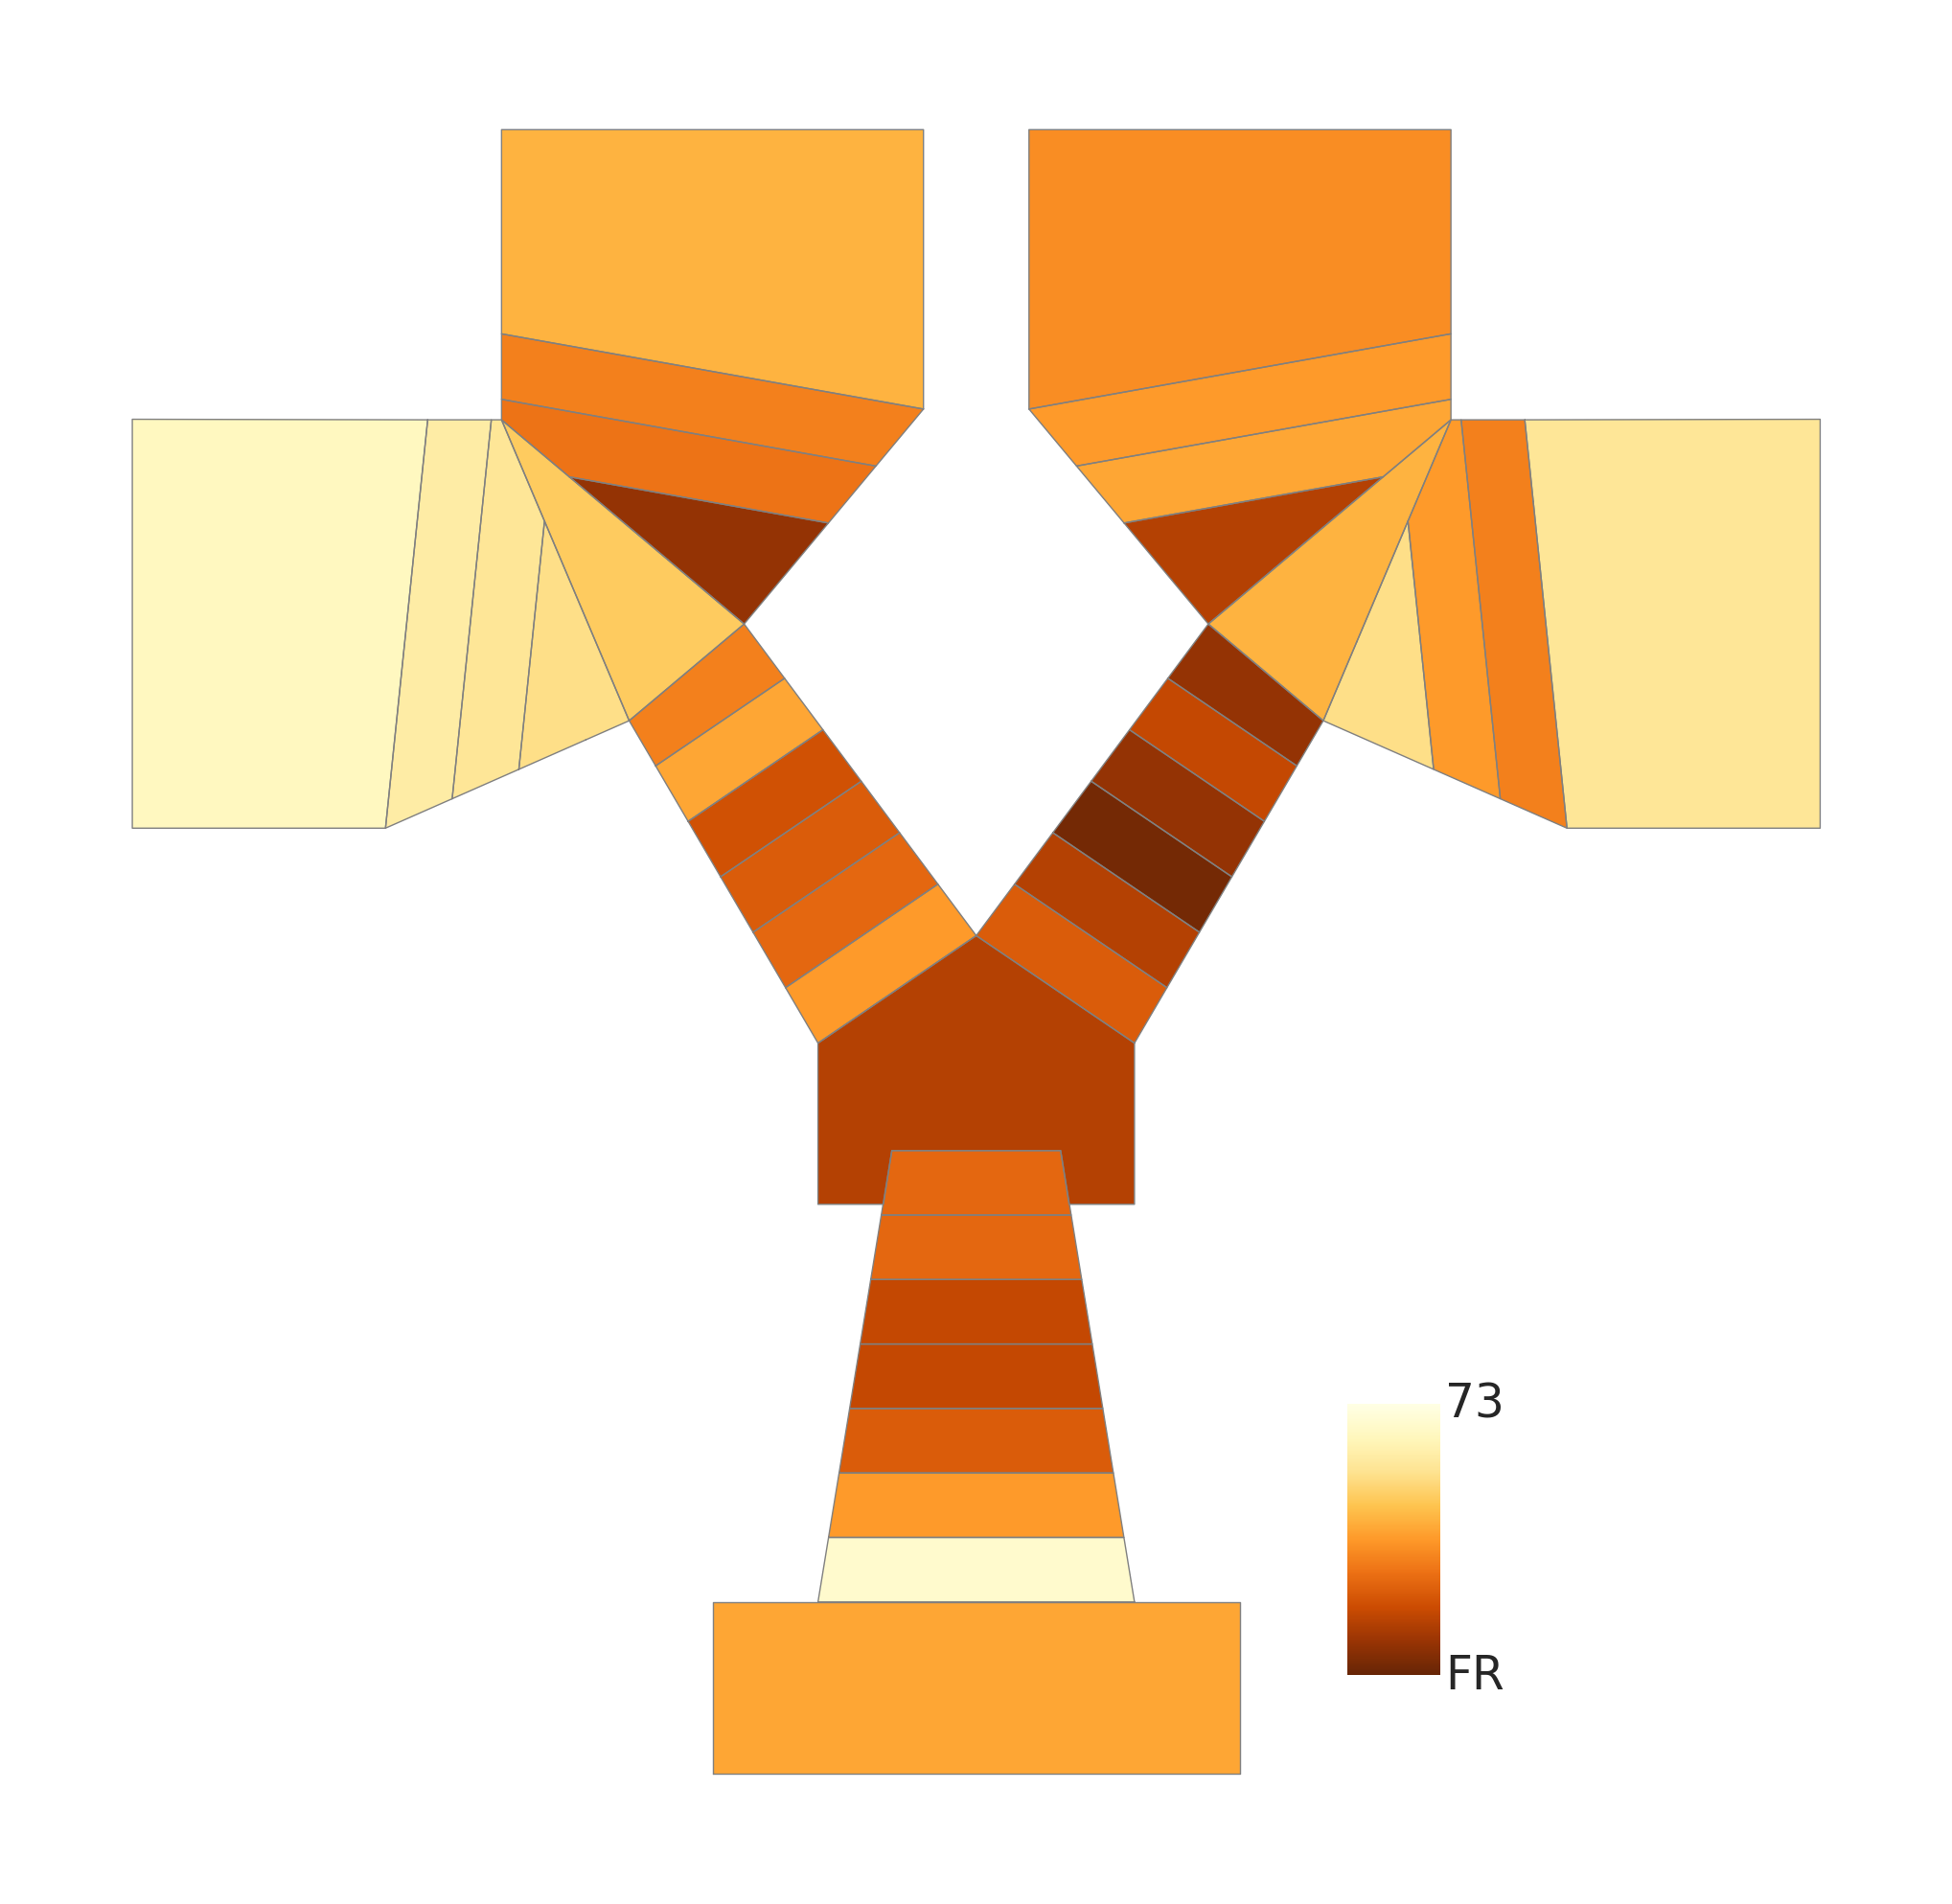

In [159]:
ta.tmz.plot_zone_activity(a.loc[0])

In [16]:
a

,H,a_0,a_1,a_2,a_3,a_4,a_5,a_6,D,b_0,...,e_5,i2,f_0,f_1,f_2,G3,g_0,g_1,g_2,G4
0,39.200217,76.076758,59.873825,55.258620,48.086322,36.723546,30.868430,26.998138,31.712249,55.904267,...,48.317828,56.429964,50.980905,55.394098,49.022483,38.897934,67.193903,86.970301,83.482241,49.144744
1,39.199652,76.054057,59.852597,55.236637,48.069891,36.714446,30.858272,26.990685,31.711783,55.861798,...,48.259387,56.408760,50.882877,55.300344,48.943457,38.878199,67.156077,86.919135,83.424746,49.140661


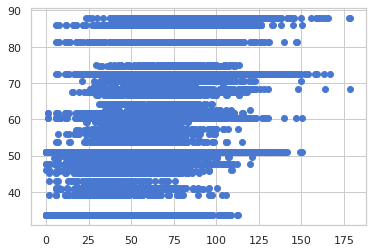

In [39]:
plt.scatter(Yte, model1.predict(Xte))